# Machine Learning Models to Predict Local Buckling Strength of CFS Channels with Staggered Web Perforations

L. Simwanda a
, 
P. Gatheeshgar b
, 
M. Sykora a
, 
P. Sejkot a
, 
A.B. David c
, 
O.B. Olalusi d


LINK TO PUBLICATION :https://doi.org/10.1016/j.jcsr.2025.110024


CODE BY: LENGANJI COPYRIGHT (c) 2026

This notebook enables the prediction of the ultimate bending capacity under local buckling, of cold-formed steel (CFS) beams with staggered slotted web perforations using advanced ensemble machine learning models. The models implemented include random forest (RF), adaptive boosting (AdaBoost), gradient boosting machine (GBM), extreme gradient boosting (XGBoost), light gradient boosting machine (LightGBM), and categorical boosting (CatBoost). These models were developed from a dataset of 432 validated finite element (FE) simulations reported by Degtyareva et al. (2020), which examined the influence of staggered perforations on local buckling strength and proposed design rules for designing CFS section with staggered slotted web perforations. Hyperparameters for each algorithm were fine-tuned through Bayesian optimization to maximize predictive performance.



# 1. Dataset EDA

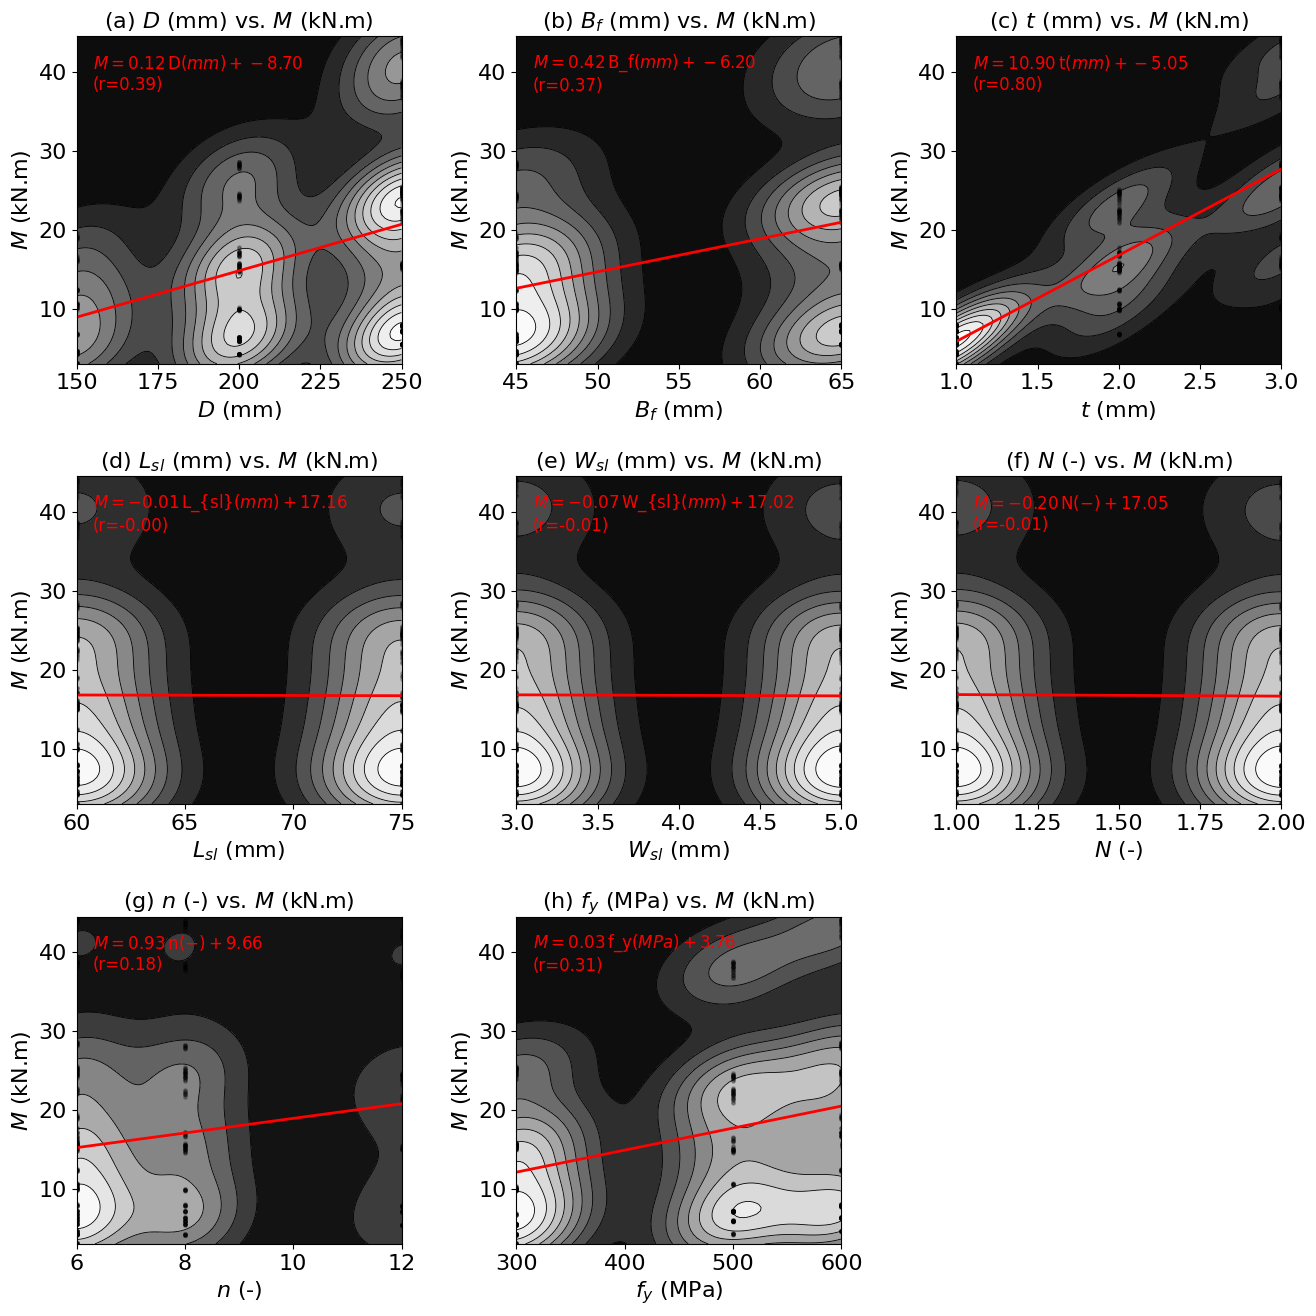

Skipped features (not plotted):
  - $B_l$ (mm): insufficient variation
  - $S_{sl}$ (mm): insufficient variation
  - $B_{sl}$ (mm): insufficient variation


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
import string
from numpy.linalg import LinAlgError

# --- Plot font sizes ---
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
})

# --- LaTeX labels with SI units ---
tex_labels = [
    r"$D$ (mm)",          # Depth
    r"$B_f$ (mm)",        # Flange width
    r"$B_l$ (mm)",        # Lip width
    r"$t$ (mm)",          # Thickness
    r"$L_{sl}$ (mm)",     # Slot length
    r"$W_{sl}$ (mm)",     # Slot width
    r"$S_{sl}$ (mm)",     # Slot spacing
    r"$B_{sl}$ (mm)",     # Slot edge distance
    r"$N$ (-)",           # Number of slots (dimensionless)
    r"$n$ (-)",           # Ratio parameter (dimensionless)
    r"$f_y$ (MPa)",       # Yield stress
    r"$M$ (kN.m)"    # Bending moment / capacity
]

# Consistent label for target
M_LABEL = r"$M$ (kN.m)"
target = M_LABEL

# --- Load data & rename columns ---
data = pd.read_excel("datasets/Data.xlsx")
if len(data.columns) != len(tex_labels):
    raise ValueError(
        f"Column count mismatch: file has {len(data.columns)} columns, "
        f"but tex_labels has {len(tex_labels)}."
    )
data.columns = tex_labels

# Clean data
data = data.replace([np.inf, -np.inf], np.nan).dropna()
numeric_data = data.select_dtypes(include=[np.number])

# --- Define features (exclude target M) ---
features = [c for c in numeric_data.columns if c != target]
y = numeric_data[target]

# --- Pre-filter features that can support KDE ---
plottable, skipped = [], {}
for f in features:
    x = numeric_data[f]
    if x.nunique() < 2 or y.nunique() < 2:
        skipped[f] = "insufficient variation"
        continue
    try:
        _ = gaussian_kde(np.vstack([x.values, y.values]))
        plottable.append(f)
    except LinAlgError:
        skipped[f] = "singular covariance"

if not plottable:
    raise RuntimeError("No features have sufficient variation for KDE.")

# --- Precompute KDE grids ---
kde_grids = {}
for f in plottable:
    x = numeric_data[f].values
    xy = np.vstack([x, y.values])
    kde = gaussian_kde(xy)
    xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
    zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
    kde_grids[f] = (xi, yi, zi)

# --- Figure layout ---
n_cols = 3
n_rows = -(-len(plottable) // n_cols)  # ceil division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 4.5 * n_rows))
axes = np.array(axes).reshape(-1)

for i, feature in enumerate(plottable):
    ax = axes[i]
    xi, yi, zi = kde_grids[feature]

    # Density contour plot
    cf = ax.contourf(xi, yi, zi, levels=10, cmap="Greys_r")
    ax.contour(xi, yi, zi, levels=10, colors="black", linewidths=0.6)

    # Raw scatter points
    x = numeric_data[feature].values
    ax.scatter(x, y.values, s=6, alpha=0.2, color="k")

    # Correlation & regression line
    slope, intercept, r_val, _, _ = linregress(x, y.values)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color="red", lw=2)

    # Equation annotation (red font)
    eq_text = fr"$M = {slope:.2f}\,{feature} + {intercept:.2f}$" + f"\n(r={r_val:.2f})"
    ax.text(0.05, 0.95, eq_text, transform=ax.transAxes,
            fontsize=12, color="red", ha="left", va="top")

    subplot_label = f"({string.ascii_lowercase[i]})"
    ax.set_title(f"{subplot_label} {feature} vs. {M_LABEL}")
    ax.set_xlabel(feature)
    ax.set_ylabel(M_LABEL)

# Remove unused axes
for j in range(len(plottable), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("figs/KDE_VISUAL.pdf", dpi=300)
plt.show()

# Report skipped features
if skipped:
    print("Skipped features (not plotted):")
    for k, v in skipped.items():
        print(f"  - {k}: {v}")


          count      mean       std       min       25%       50%       75%  \
$D$       432.0  216.6667   37.3110  150.0000  200.0000  225.0000  250.0000   
$B_f$     432.0   55.0000   10.0116   45.0000   45.0000   55.0000   65.0000   
$B_l$     432.0   13.0000    0.0000   13.0000   13.0000   13.0000   13.0000   
$t$       432.0    2.0000    0.8174    1.0000    1.0000    2.0000    3.0000   
$L_{sl}$  432.0   67.5000    7.5087   60.0000   60.0000   67.5000   75.0000   
$W_{sl}$  432.0    4.0000    1.0012    3.0000    3.0000    4.0000    5.0000   
$S_{sl}$  432.0  100.0000    0.0000  100.0000  100.0000  100.0000  100.0000   
$B_{sl}$  432.0    9.5000    0.0000    9.5000    9.5000    9.5000    9.5000   
$N$       432.0    1.5000    0.5006    1.0000    1.0000    1.5000    2.0000   
$n$       432.0    7.6667    2.1368    6.0000    6.0000    7.0000    8.0000   
$f_y$     432.0  466.6667  124.8665  300.0000  300.0000  500.0000  600.0000   
$M$       432.0   16.7595   11.1846    3.0279    7.1

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pandas\plotting\_matplotlib\misc.py:100: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\pandas\plotting\_matplotlib\misc.py:91: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])
C:\Users\DELL\AppData\L

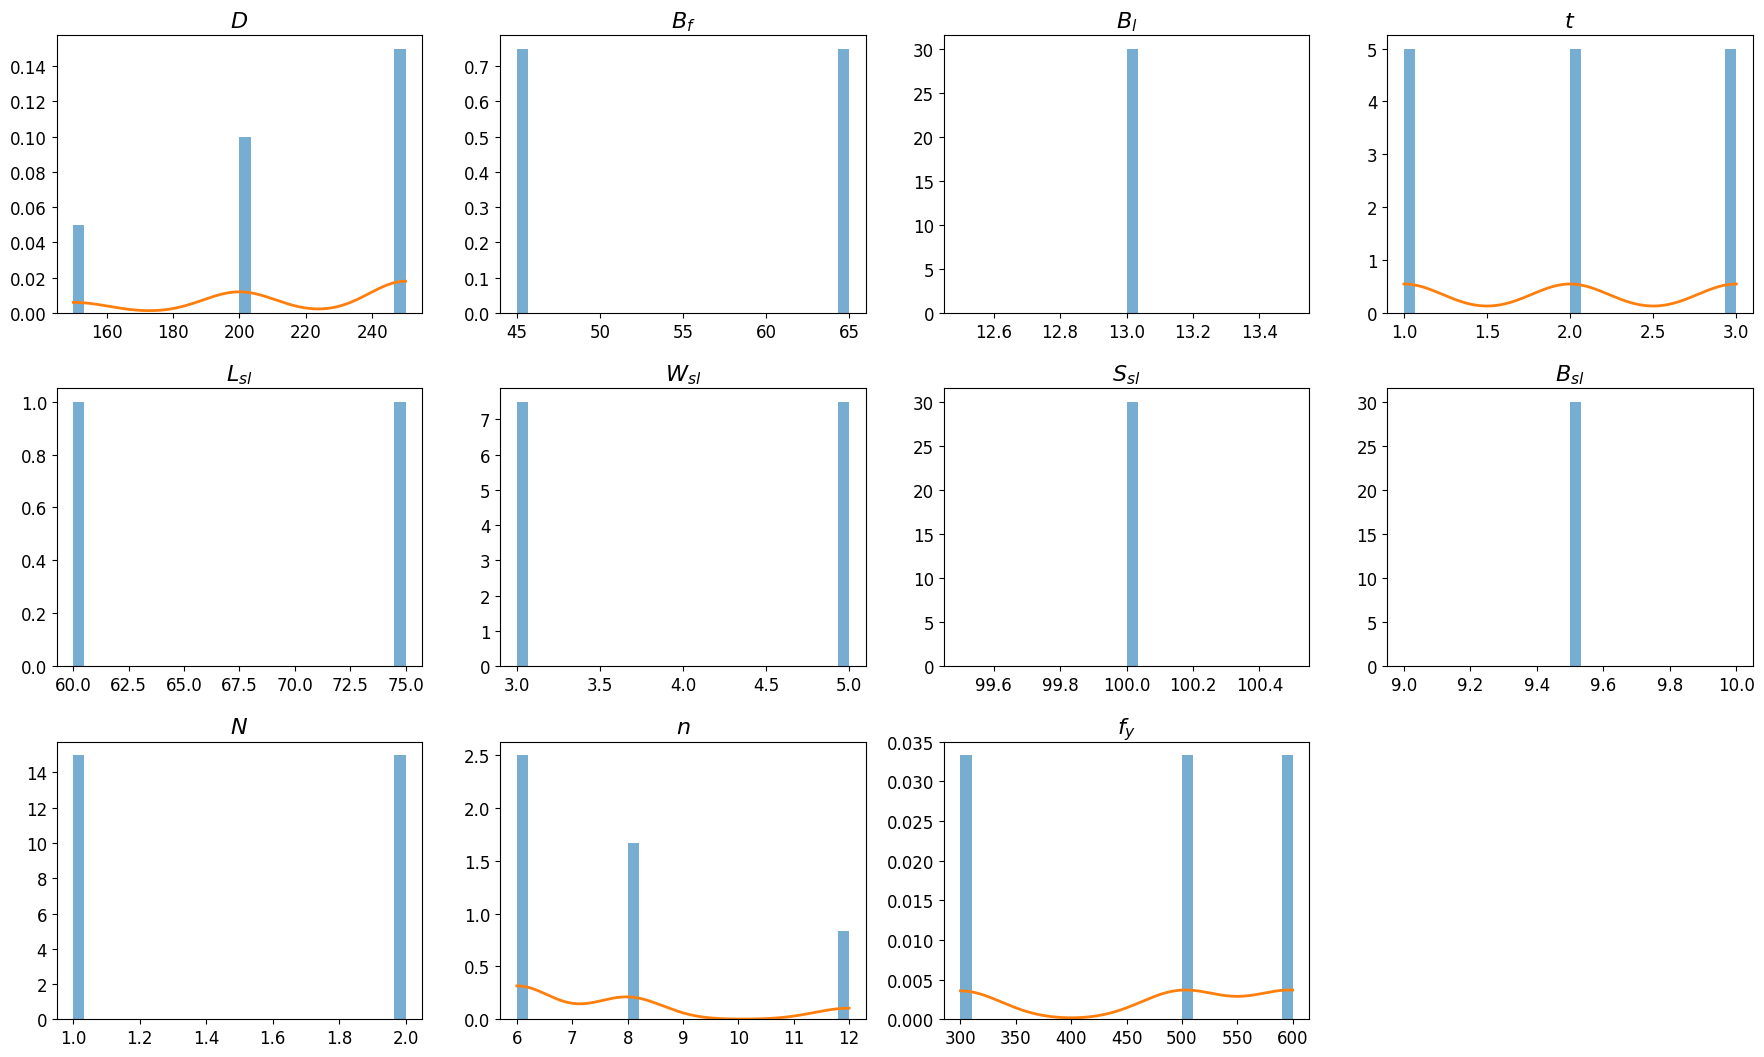

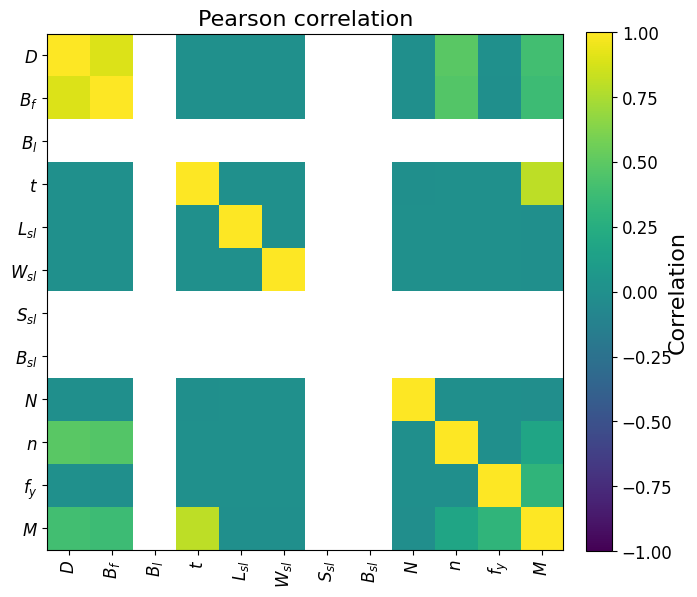

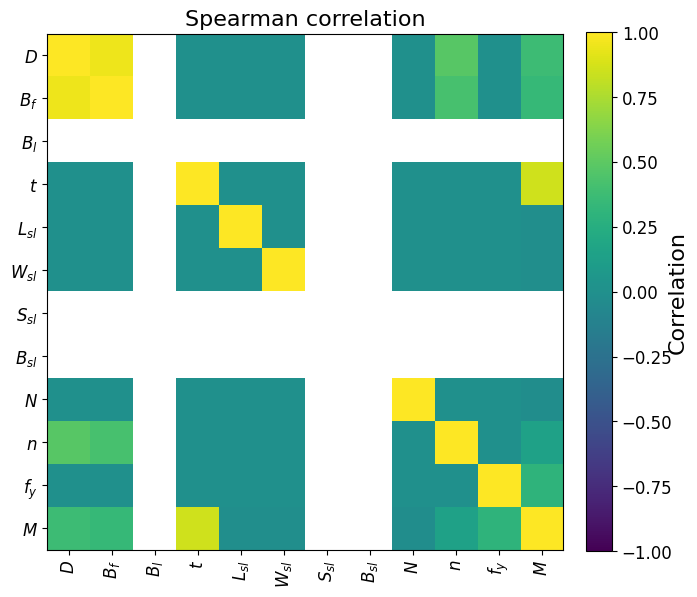

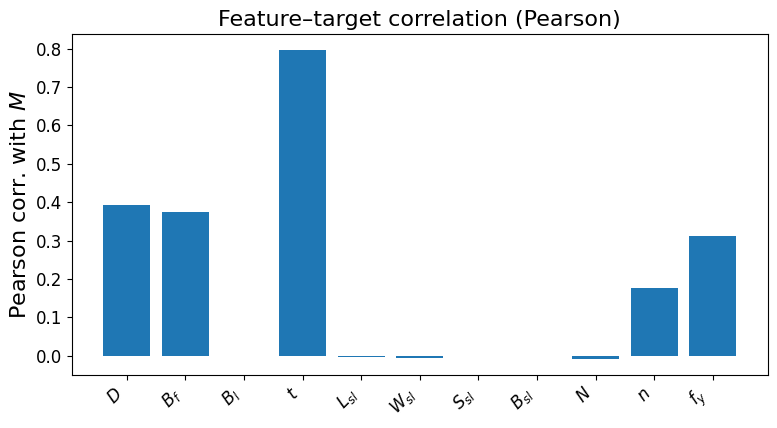

<Figure size 1920x1920 with 0 Axes>

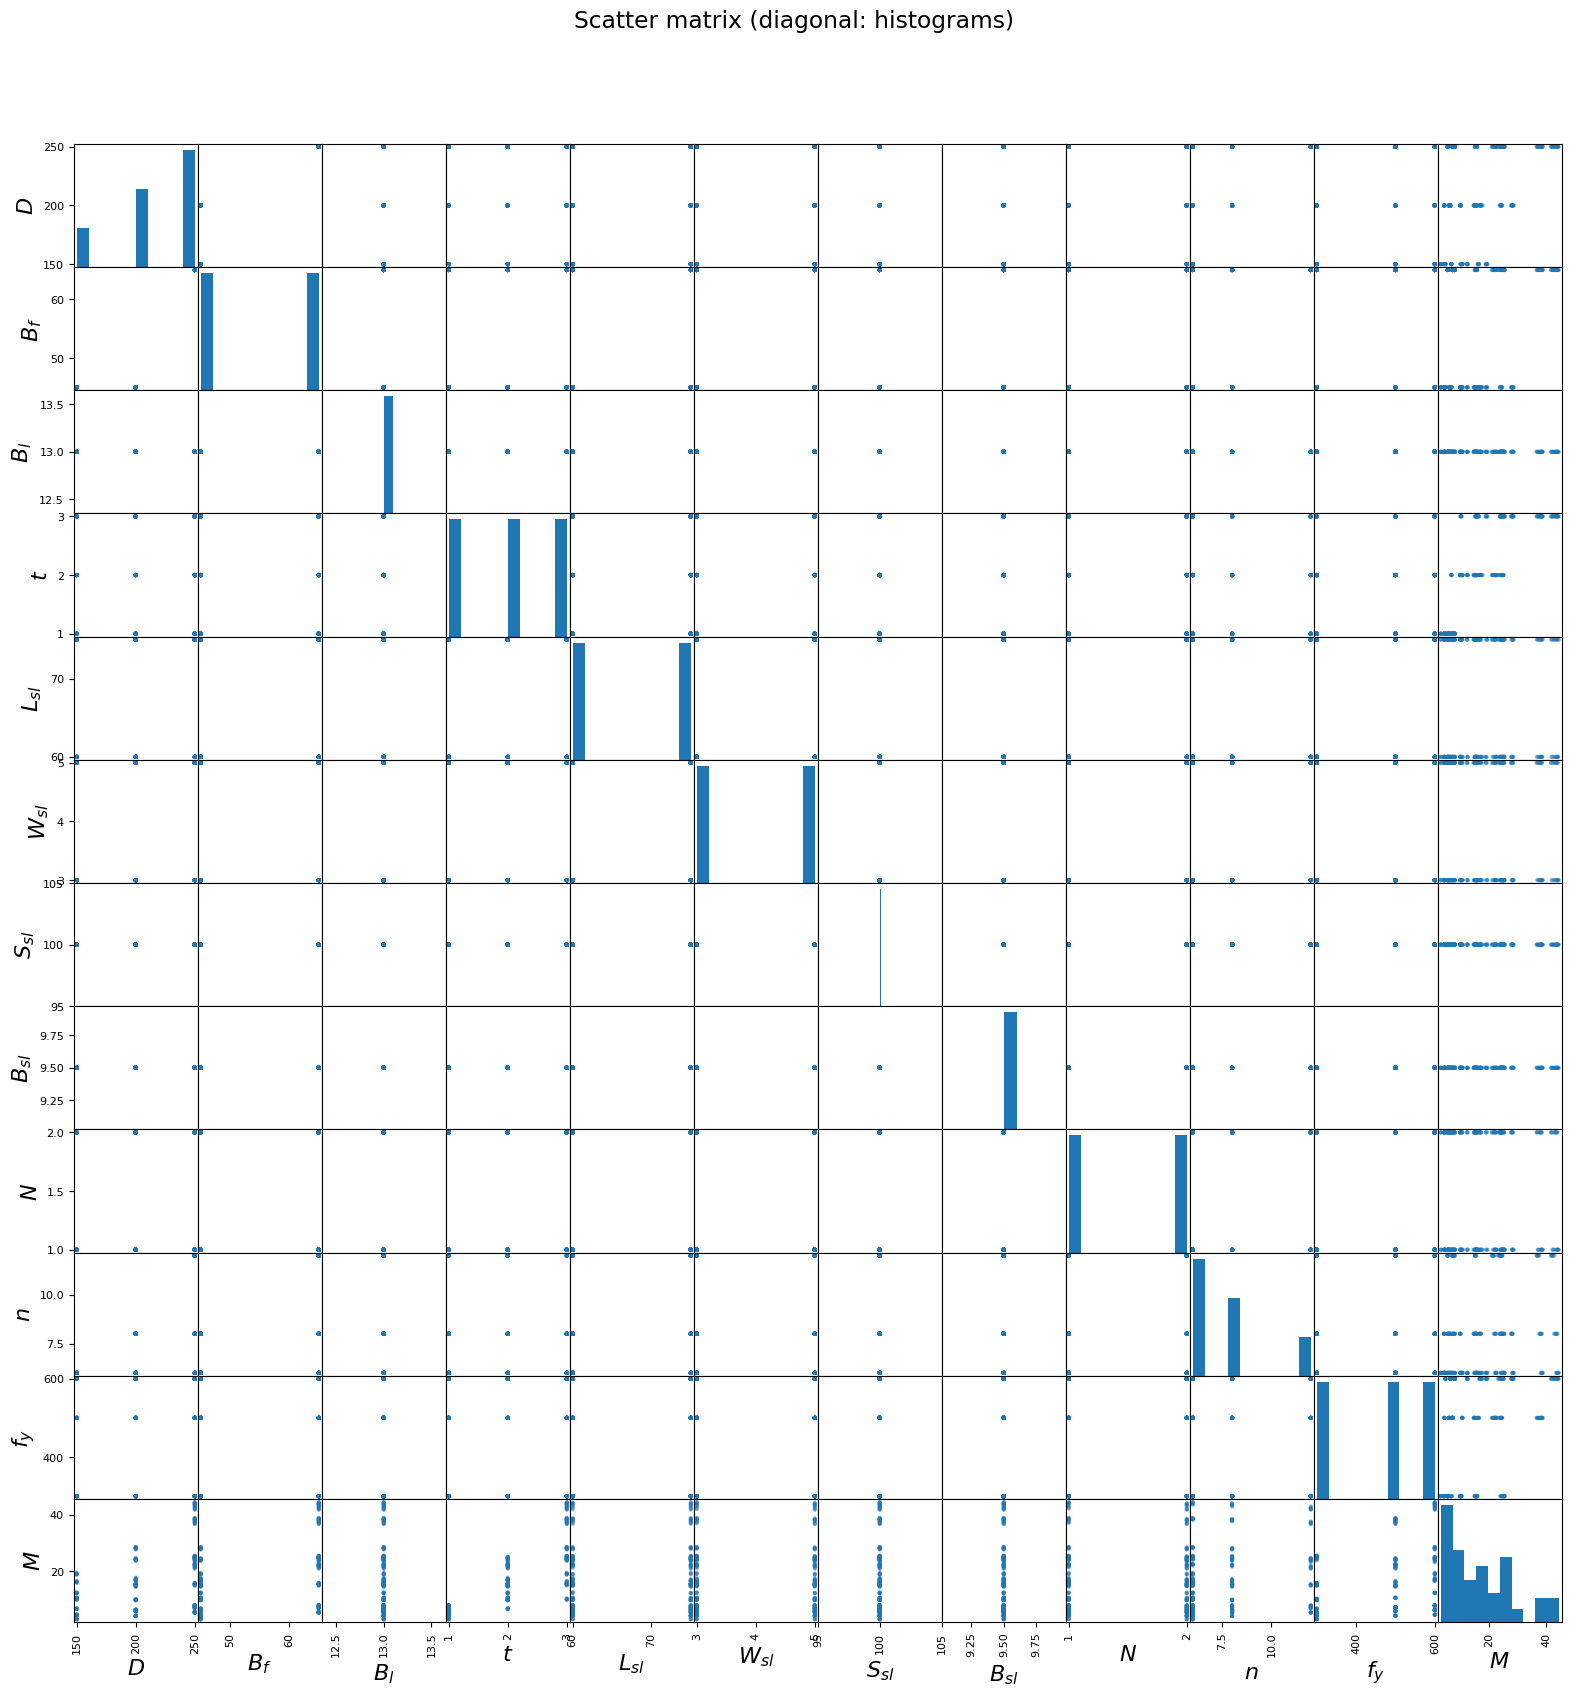

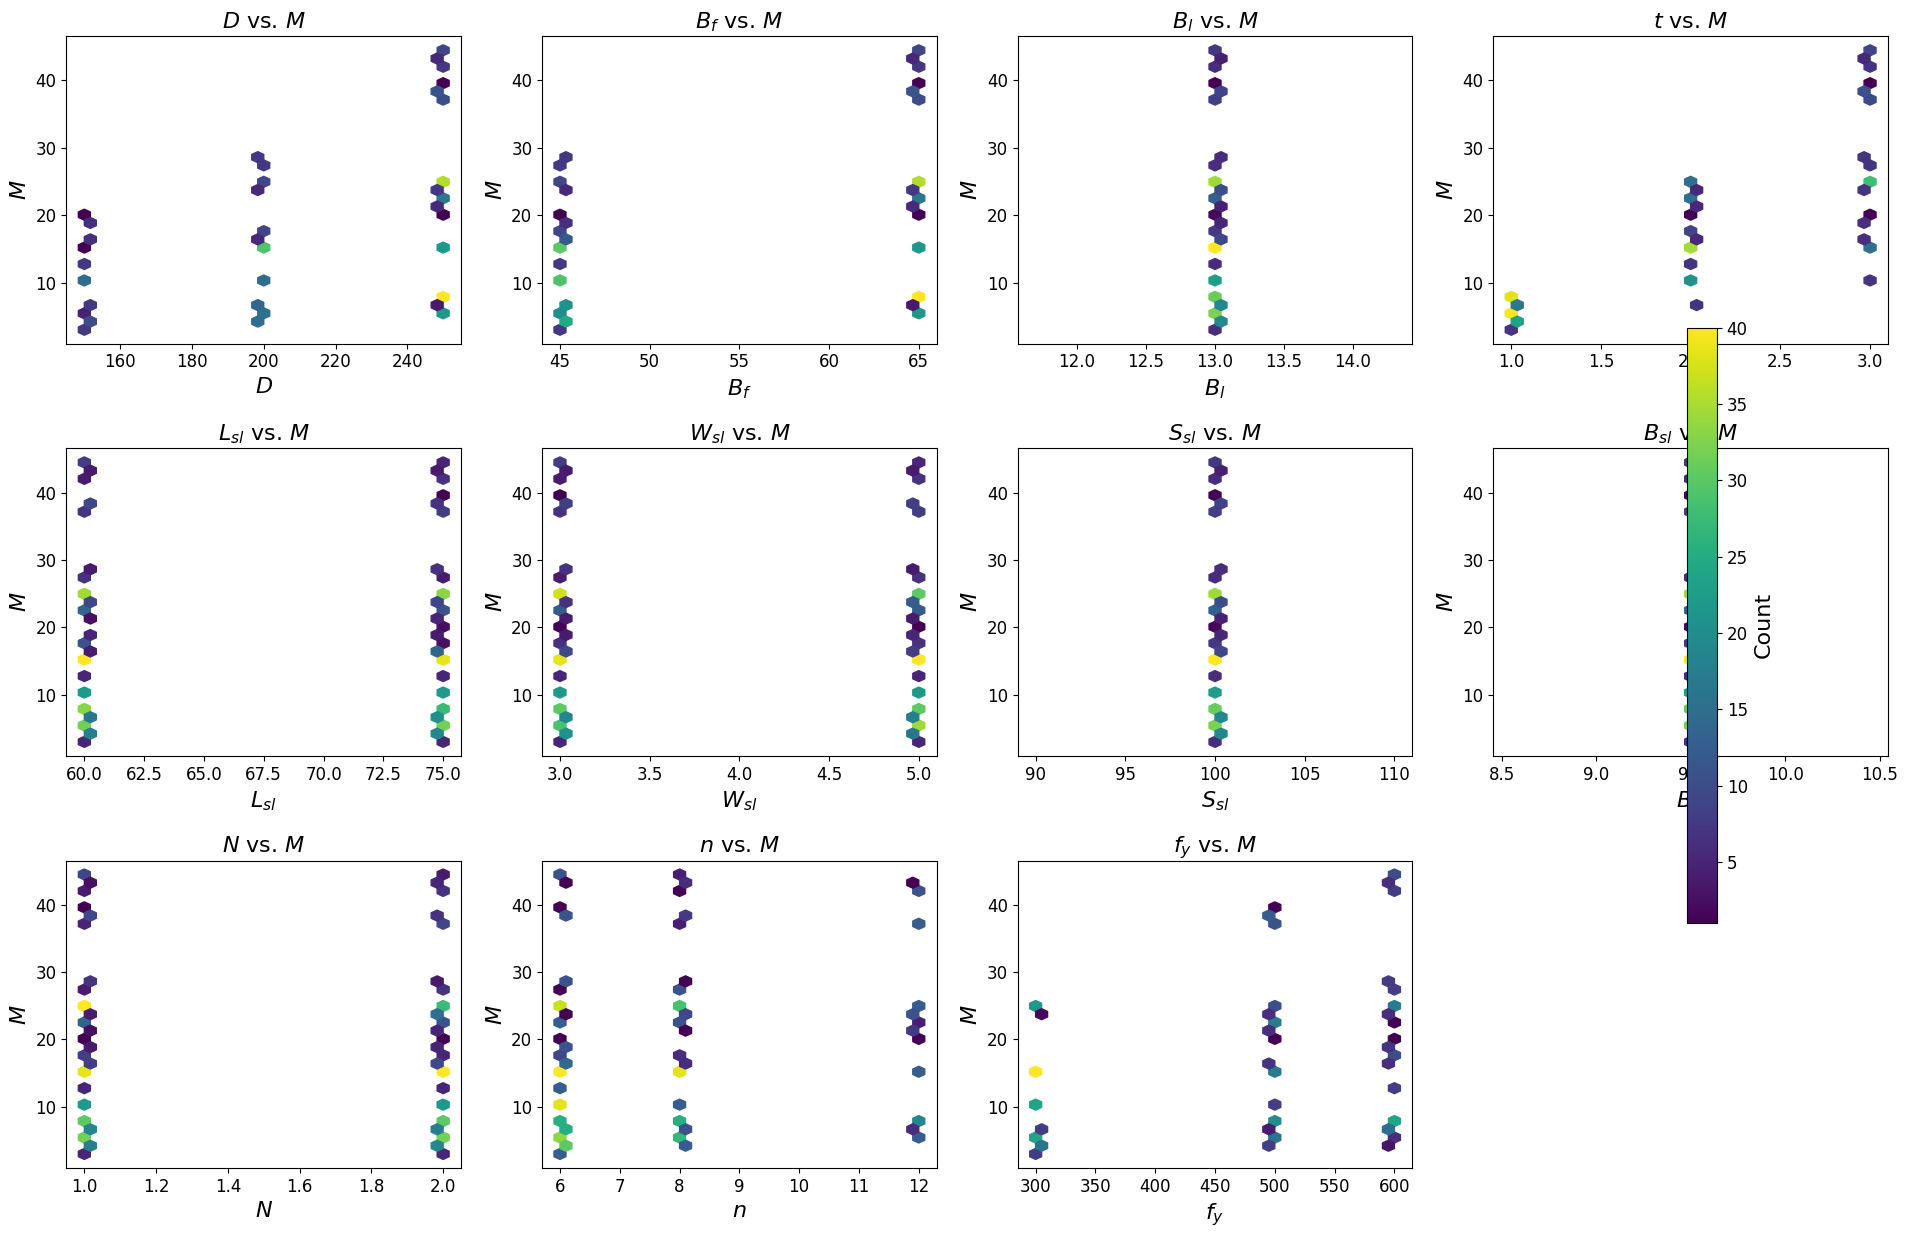

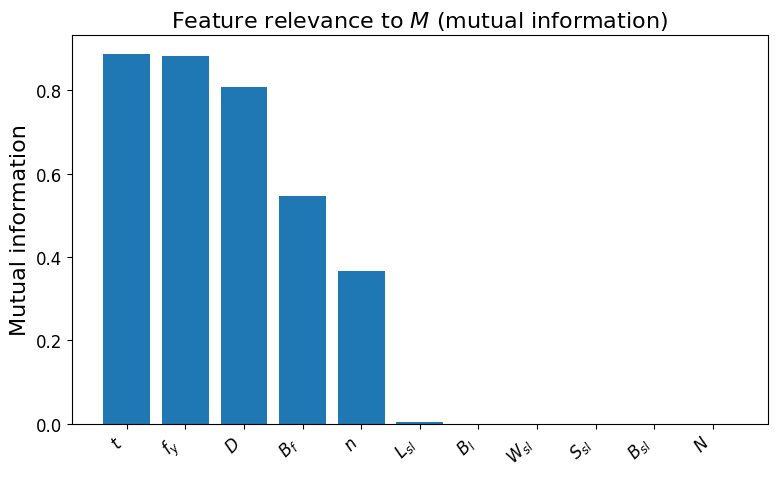

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, spearmanr
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from pandas.plotting import scatter_matrix
from numpy.linalg import LinAlgError

# ---------------- Global Matplotlib style ----------------
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# ---------------- Config ----------------
tex_labels = [
    r"$D$", r"$B_f$", r"$B_l$", r"$t$", r"$L_{sl}$", r"$W_{sl}$",
    r"$S_{sl}$", r"$B_{sl}$", r"$N$", r"$n$", r"$f_y$", r"$M$"
]
TARGET = r"$M$"

# ---------------- Load & prepare ----------------
df = pd.read_excel("datasets/Data.xlsx")
assert len(df.columns) == len(tex_labels), "Column count mismatch."
df.columns = tex_labels

df = df.replace([np.inf, -np.inf], np.nan).dropna()
num = df.select_dtypes(include=[np.number])
features = [c for c in num.columns if c != TARGET]
X = num[features].copy()
y = num[TARGET].copy()

# ---------------- 0) Summary table (quick sanity) ----------------
summary = num.describe().T
print(summary)  # optional

# ---------------- 1) Univariate hist + KDE ----------------
n = len(features)
n_cols = 4
n_rows = -(-n // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5*n_cols, 3.6*n_rows))
axes = axes.ravel()

for i, f in enumerate(features):
    ax = axes[i]
    x = X[f].values
    ax.hist(x, bins=30, density=True, alpha=0.6)
    if np.unique(x).size > 2:
        try:
            kde = gaussian_kde(x)
            xs = np.linspace(x.min(), x.max(), 400)
            ax.plot(xs, kde(xs), linewidth=2)
        except LinAlgError:
            pass
    ax.set_title(f"{f}")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.savefig("figs/01_hist_kde_features.pdf", dpi=300)

# ---------------- 2) Correlation heatmaps ----------------
def heatmap(corr, title, fname):
    fig, ax = plt.subplots(figsize=(0.6*len(corr), 0.6*len(corr)))
    im = ax.imshow(corr, vmin=-1, vmax=1, aspect='equal')
    ax.set_xticks(range(len(corr)))
    ax.set_yticks(range(len(corr)))
    ax.set_xticklabels(corr.columns, rotation=90)
    ax.set_yticklabels(corr.index)
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Correlation", rotation=90, va="center")
    plt.tight_layout()
    plt.savefig(fname, dpi=300)

pearson = num.corr(method="pearson")
heatmap(pearson, "Pearson correlation", "figs/02_corr_pearson.pdf")

# Spearman (rank) across numeric columns:
spearman_mat = pd.DataFrame(np.eye(len(num.columns)), index=num.columns, columns=num.columns)
for i, a in enumerate(num.columns):
    for j, b in enumerate(num.columns):
        if j >= i:
            rho, _ = spearmanr(num[a], num[b])
            spearman_mat.loc[a, b] = rho
            spearman_mat.loc[b, a] = rho
heatmap(spearman_mat, "Spearman correlation", "figs/03_corr_spearman.pdf")

# ---------------- 3) Correlation with target (bar) ----------------
with_target = pearson[TARGET].drop(TARGET)
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.bar(range(len(with_target)), with_target.values)
ax.set_xticks(range(len(with_target)))
ax.set_xticklabels(with_target.index, rotation=45, ha='right')
ax.set_ylabel("Pearson corr. with " + TARGET)
ax.set_title("Feature–target correlation (Pearson)")
plt.tight_layout()
plt.savefig("figs/04_corr_with_target_bar.pdf", dpi=300)

# ---------------- 4) Pairwise scatter matrix ----------------
# (May be heavy if many rows; tune 'alpha' & 'figsize' as needed.)
sm_cols = features + [TARGET]
fig = plt.figure(figsize=(1.6*len(sm_cols), 1.6*len(sm_cols)))
scatter_matrix(num[sm_cols], figsize=(1.6*len(sm_cols), 1.6*len(sm_cols)),
               diagonal='hist', alpha=0.4)
plt.suptitle("Scatter matrix (diagonal: histograms)", y=0.95)
plt.savefig("figs/05_scatter_matrix.pdf", dpi=300, bbox_inches="tight")

# ---------------- 5) Hexbin: each feature vs M ----------------
n_cols = 4
n_rows = -(-len(features) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 4.2*n_rows), squeeze=False)
axes = axes.ravel()
for i, f in enumerate(features):
    ax = axes[i]
    hb = ax.hexbin(X[f].values, y.values, gridsize=30, mincnt=1)
    ax.set_xlabel(f)
    ax.set_ylabel(TARGET)
    ax.set_title(f"{f} vs. {TARGET}")
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
cbar = fig.colorbar(hb, ax=axes.tolist(), fraction=0.02, pad=0.01)
cbar.set_label("Count")
plt.tight_layout()
plt.savefig("figs/06_hexbin_feature_vs_target.pdf", dpi=300)

# ---------------- 6) Mutual Information (nonlinear dependence) ----------------
# MI needs finite data; already cleaned above.
mi = mutual_info_regression(X.values, y.values, random_state=42)
mi_s = pd.Series(mi, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(len(mi_s)), mi_s.values)
ax.set_xticks(range(len(mi_s)))
ax.set_xticklabels(mi_s.index, rotation=45, ha='right')
ax.set_ylabel("Mutual information")
ax.set_title("Feature relevance to " + TARGET + " (mutual information)")
plt.tight_layout()
plt.savefig("figs/07_mutual_information.pdf", dpi=300)




# 2 MODEL TRAINING

# 2.1 Random forest

In [9]:
import optuna
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages

# Load data from the Excel file
df = pd.read_excel('datasets/Data.xlsx', engine='openpyxl')
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize a list to store trials' results for plotting
results = []

# Define the objective function for Bayesian optimization
def objective(trial):
    # Define hyperparameters for Random Forest
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    # Train and evaluate the model
    model = RandomForestRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)

    # Store results for plotting
    results.append((param['n_estimators'], param['max_depth'], score))
    return score

# Create and run the study
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(study_name="my_study",
    storage="sqlite:///optuna.db",
    load_if_exists=True
                            ,
    direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)

# Extract the results for plotting
n_estimators, max_depths, scores = zip(*results)


# Print the best parameters and scores
best_params = study.best_params
print(f"Best Parameters: {best_params}")
print(f"Optimized Random Forest Training R² Score: {r2_score(y_train, rf.predict(X_train))}")
print(f"Optimized Random Forest Test R² Score: {r2_score(y_test, rf.predict(X_test))}")


Best Parameters: {'n_estimators': 682, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Optimized Random Forest Training R² Score: 0.9961305533380204
Optimized Random Forest Test R² Score: 0.9621731768108239


# 2.2 Adaboost

In [26]:
import optuna
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Initialize a list to store trials' results for plotting
results = []

def objective(trial):
    # Define hyperparameters for AdaBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'estimator': DecisionTreeRegressor(
            max_depth=trial.suggest_int('max_depth', 2, 10)
        )
    }

    model = AdaBoostRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return r2_score(y_test, y_pred)  # or whichever metric you want

# Create and run the study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)


# Extract best parameters
best_params = study.best_params

# Rebuild the base estimator correctly
base_estimator = DecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    random_state=42
)

# Build final AdaBoost model
ada = AdaBoostRegressor(
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    estimator=base_estimator,
    random_state=42
)

# Train model
ada.fit(X_train, y_train)

# Predictions
ada_y_train_pred = ada.predict(X_train)
ada_y_test_pred = ada.predict(X_test)

# R² scores
r2_train = r2_score(y_train, ada_y_train_pred)
r2_test = r2_score(y_test, ada_y_test_pred)

print(f"Optimized AdaBoost Training R² Score: {r2_train:.4f}")
print(f"Optimized AdaBoost Test R² Score: {r2_test:.4f}")

Optimized AdaBoost Training R² Score: 1.0000
Optimized AdaBoost Test R² Score: 0.9997


# 2.3 GBM

In [16]:
import optuna
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# Define the objective function for Bayesian optimization
def objective(trial):
    # Parameters to tune
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    model = GradientBoostingRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(study_name="my_study",
    storage="sqlite:///optuna.db",
    load_if_exists=True
                            ,
    direction='maximize')
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=50, timeout=600)

# Retrieve and print the best parameters after optimization
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train the final model with the best parameters
gbm = GradientBoostingRegressor(**best_params, random_state=42)
gbm.fit(X_train, y_train)

# Predict on both training and test sets and calculate R²
gbm_y_train_pred = gbm.predict(X_train)
gbm_y_test_pred = gbm.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, gbm_y_train_pred)
r2_test = r2_score(y_test, gbm_y_test_pred)

# Print the results
print(f"Optimized GBM Training R² Score: {r2_train}")
print(f"Optimized GBM Test R² Score: {r2_test}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\3535603969.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\3535603969.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\3535603969.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_logun

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\3535603969.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\3535603969.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\3535603969.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_logun

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\3535603969.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),


Best Parameters: {'n_estimators': 428, 'learning_rate': 0.0712714245328877, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'log2', 'subsample': 0.983234926048238}
Optimized GBM Training R² Score: 0.9998243573269509
Optimized GBM Test R² Score: 0.9991776121787642


# 2.4 LightGBM

In [17]:
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


import lightgbm as lgb

def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'l2',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 20)
    }

    # Create dataset for lightgbm
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_test, label=y_test, reference=dtrain)

    # List of callbacks including early stopping
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, verbose=100)
    ]

    # Model training
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=callbacks)

    # Predictions
    preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    # Evaluation
    return r2_score(y_test, preds)


# Create the Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=100, timeout=3600)  # Setting a longer timeout, adjust as per your computational resources

# Retrieve and print the best parameters after optimization
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train the final model with the best parameters on the full training set
lgbm = lgb.LGBMRegressor(**{k: v for k, v in best_params.items() if k not in ['n_estimators', 'verbosity', 'objective', 'metric', 'boosting_type']})
lgbm.fit(X_train, y_train)

# Predict on both training and test sets and calculate R²
lgbm_y_train_pred = lgbm.predict(X_train)
lgbm_y_test_pred = lgbm.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, lgbm_y_train_pred)
r2_test = r2_score(y_test, lgbm_y_test_pred)

# Print the results
print(f"Optimized LightGBM Training R² Score: {r2_train}")
print(f"Optimized LightGBM Test R² Score: {r2_test}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[385]	valid_0's l2: 25.6349
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
T

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[335]	valid_0's l2: 0.139926


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[347]	valid_0's l2: 2.83216


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: Futu

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's l2: 0.149256


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: Future

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[256]	valid_0's l2: 0.0317547
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's l2: 118.072
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[243]	valid_0's l2: 0.426631


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[195]	valid_0's l2: 119.168
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[236]	valid_0's l2: 10.0927
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: Future

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[225]	valid_0's l2: 1.69942
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 118.667


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: sug

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[336]	valid_0's l2: 0.0369573
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[280]	valid_0's l2: 0.0347818
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[180]	valid_0's l2: 4.92845


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 118.845
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[443]	valid_0's l2: 0.885281
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[14]	valid_0's l2: 119.046


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[396]	valid_0's l2: 0.262935


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	valid_0's l2: 118.436
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's l2: 3.36834


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 0.10036
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[165]	valid_0's l2: 0.34703
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[120]	valid_0's l2: 10.0054


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[387]	valid_0's l2: 3.1318
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[305]	valid_0's l2: 0.491066
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[436]	valid_0's l2: 3.10962
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: sug

Early stopping, best iteration is:
[148]	valid_0's l2: 24.8425
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[134]	valid_0's l2: 0.705089


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[328]	valid_0's l2: 0.13685


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[289]	valid_0's l2: 0.156195
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: sug

Early stopping, best iteration is:
[224]	valid_0's l2: 9.93638
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[245]	valid_0's l2: 1.25041


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[439]	valid_0's l2: 0.278682
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: sug

Did not meet early stopping. Best iteration is:
[496]	valid_0's l2: 32.3685
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[605]	valid_0's l2: 0.0344357
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[601]	valid_0's l2: 11.6296


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[18]	valid_0's l2: 119.59
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[572]	valid_0's l2: 0.0198877


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[589]	valid_0's l2: 0.251993


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[649]	valid_0's l2: 0.0638336


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	valid_0's l2: 19.5965


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[623]	valid_0's l2: 0.161512


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[720]	valid_0's l2: 4.94674
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[573]	valid_0's l2: 0.0874096
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[558]	valid_0's l2: 0.431784


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[576]	valid_0's l2: 0.132034
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[659]	valid_0's l2: 9.63969
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[717]	valid_0's l2: 2.87225
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[474]	valid_0's l2: 0.214167
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[238]	valid_0's l2: 9.50663


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: sug

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[628]	valid_0's l2: 0.0469286


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[203]	valid_0's l2: 10.4674


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[260]	valid_0's l2: 0.495825
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[609]	valid_0's l2: 0.0902182
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[524]	valid_0's l2: 0.339741
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[674]	valid_0's l2: 0.701921
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	valid_0's l2: 10.0521


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[480]	valid_0's l2: 0.393674


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[624]	valid_0's l2: 0.024045


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[535]	valid_0's l2: 0.727579


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[440]	valid_0's l2: 9.5349
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Early stopping, best iteration is:
[240]	valid_0's l2: 9.72292
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[146]	valid_0's l2: 0.524581


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: Future

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[556]	valid_0's l2: 0.0459924


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[531]	valid_0's l2: 0.253639


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[522]	valid_0's l2: 0.0315432


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[363]	valid_0's l2: 2.50747


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[424]	valid_0's l2: 0.0270955


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[358]	valid_0's l2: 0.157588


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[264]	valid_0's l2: 0.0428455


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[420]	valid_0's l2: 0.0139415


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[344]	valid_0's l2: 3.09624


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[279]	valid_0's l2: 0.0473658
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[327]	valid_0's l2: 0.175045
Training until validation scores don't improve for 100 rounds


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Did not meet early stopping. Best iteration is:
[266]	valid_0's l2: 0.0319953
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[232]	valid_0's l2: 1.00621


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[404]	valid_0's l2: 0.0298873


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[390]	valid_0's l2: 0.110886


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[412]	valid_0's l2: 0.066532


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e-1),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:24: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\944473675.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform(

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l2: 137.246
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[443]	valid_0's l2: 0.011364
Best Parameters: {'num_leaves': 90, 'learning_rate': 0.2897462496468565, 'n_estimators': 444, 'max_depth': 26, 'min_child_samples': 26, 'min_child_weight': 0.09031628813977134, 'subsample': 0.9208642711780175, 'colsample_bytree': 0.9342224540244369, 'reg_alpha': 0.0027308794685430298, 'reg_lambda': 0.005962404488217008, 'subsample_freq': 17}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28
[LightGBM] [Info] Number of data points in the train set: 302, number of used features: 8
[LightGBM] [Info] Start training from score 16.920460
[LightGBM] [Warning] No further splits with positive gai

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# 2.5 CatBoost

In [18]:
import optuna
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define the objective function for Bayesian optimization
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 50, 255),
        'loss_function': 'RMSE',
        'verbose': False
    }

    model = CatBoostRegressor(**param, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=0)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)

# Create the Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=100, timeout=3600)  # Adjust the timeout as per your computational resources

# Retrieve and print the best parameters after optimization
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train the final model with the best parameters
cat = CatBoostRegressor(**best_params, random_state=42)
cat.fit(X_train, y_train)

# Predict on both training and test sets and calculate R²
cat_y_train_pred = cat.predict(X_train)
cat_y_test_pred = cat.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, cat_y_train_pred)
r2_test = r2_score(y_test, cat_y_test_pred)

# Print the results
print(f"Optimized CatBoost Training R² Score: {r2_train}")
print(f"Optimized CatBoost Test R² Score: {r2_test}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 1.0),
C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\1560701487.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.sug

Best Parameters: {'iterations': 786, 'depth': 4, 'learning_rate': 0.21799397595354505, 'random_strength': 76, 'bagging_temperature': 0.05578446996091, 'l2_leaf_reg': 1.111756020088472, 'border_count': 240}
0:	learn: 9.3527796	total: 480us	remaining: 377ms
1:	learn: 7.7371480	total: 842us	remaining: 330ms
2:	learn: 6.8483228	total: 1.33ms	remaining: 348ms
3:	learn: 6.0026154	total: 1.74ms	remaining: 341ms
4:	learn: 5.3895331	total: 2.16ms	remaining: 338ms
5:	learn: 4.5272720	total: 2.59ms	remaining: 336ms
6:	learn: 4.0502120	total: 3.02ms	remaining: 336ms
7:	learn: 3.7758009	total: 3.41ms	remaining: 332ms
8:	learn: 3.5266347	total: 3.76ms	remaining: 324ms
9:	learn: 3.4198734	total: 4.07ms	remaining: 316ms
10:	learn: 3.1140526	total: 4.43ms	remaining: 312ms
11:	learn: 3.0474161	total: 4.73ms	remaining: 305ms
12:	learn: 2.6577041	total: 5.09ms	remaining: 303ms
13:	learn: 2.5048049	total: 5.47ms	remaining: 302ms
14:	learn: 2.4963713	total: 5.71ms	remaining: 293ms
15:	learn: 2.3857832	total

388:	learn: 0.0346061	total: 155ms	remaining: 158ms
389:	learn: 0.0345557	total: 155ms	remaining: 158ms
390:	learn: 0.0345096	total: 156ms	remaining: 157ms
391:	learn: 0.0344953	total: 156ms	remaining: 157ms
392:	learn: 0.0344425	total: 156ms	remaining: 156ms
393:	learn: 0.0344013	total: 157ms	remaining: 156ms
394:	learn: 0.0343353	total: 157ms	remaining: 156ms
395:	learn: 0.0342408	total: 158ms	remaining: 155ms
396:	learn: 0.0342249	total: 158ms	remaining: 155ms
397:	learn: 0.0341597	total: 158ms	remaining: 154ms
398:	learn: 0.0340305	total: 159ms	remaining: 154ms
399:	learn: 0.0339086	total: 159ms	remaining: 154ms
400:	learn: 0.0338271	total: 159ms	remaining: 153ms
401:	learn: 0.0337409	total: 160ms	remaining: 153ms
402:	learn: 0.0336795	total: 160ms	remaining: 152ms
403:	learn: 0.0336002	total: 161ms	remaining: 152ms
404:	learn: 0.0335521	total: 161ms	remaining: 151ms
405:	learn: 0.0335171	total: 161ms	remaining: 151ms
406:	learn: 0.0334905	total: 162ms	remaining: 150ms
407:	learn: 

763:	learn: 0.0233169	total: 313ms	remaining: 9.02ms
764:	learn: 0.0233095	total: 314ms	remaining: 8.61ms
765:	learn: 0.0233064	total: 314ms	remaining: 8.2ms
766:	learn: 0.0232919	total: 314ms	remaining: 7.79ms
767:	learn: 0.0232713	total: 315ms	remaining: 7.38ms
768:	learn: 0.0232654	total: 315ms	remaining: 6.97ms
769:	learn: 0.0232599	total: 316ms	remaining: 6.56ms
770:	learn: 0.0232512	total: 316ms	remaining: 6.15ms
771:	learn: 0.0232222	total: 317ms	remaining: 5.74ms
772:	learn: 0.0231908	total: 317ms	remaining: 5.33ms
773:	learn: 0.0231711	total: 317ms	remaining: 4.92ms
774:	learn: 0.0231647	total: 318ms	remaining: 4.51ms
775:	learn: 0.0231603	total: 318ms	remaining: 4.1ms
776:	learn: 0.0231548	total: 319ms	remaining: 3.69ms
777:	learn: 0.0231335	total: 319ms	remaining: 3.28ms
778:	learn: 0.0231297	total: 319ms	remaining: 2.87ms
779:	learn: 0.0231246	total: 320ms	remaining: 2.46ms
780:	learn: 0.0231186	total: 320ms	remaining: 2.05ms
781:	learn: 0.0231028	total: 320ms	remaining: 1.

# 2.6 XGBoost

In [19]:
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Define the objective function for Bayesian optimization
def objective(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    return r2_score(y_test, y_test_pred)

# Initialize the study and enqueue the provided parameters as the first trial
initial_params = {
    'n_estimators': 463,
    'learning_rate': 0.23562169710111447,
    'max_depth': 7,
    'min_child_weight': 7,
    'subsample': 0.813583341659057,
    'colsample_bytree': 0.9680084217485896,
    'reg_alpha': 0.0015512548150350691,
    'reg_lambda': 0.3495824137517043,
    'objective': 'reg:squarederror'
}

# Create the Optuna study
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')

# Enqueue the initial parameter set as the first trial
study.enqueue_trial(initial_params)

# Run the optimization
study.optimize(objective, n_trials=10, timeout=600)

# Retrieve and print the best parameters after optimization
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# Train the final model with the best parameters
xgb = xgb.XGBRegressor(**best_params, random_state=42)
xgb.fit(X_train, y_train)

# Predict on both training and test sets and calculate R²
xgb_y_train_pred = xgb.predict(X_train)
xgb_y_test_pred = xgb.predict(X_test)


y_train_pred =xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Print the results
print(f"Optimized XGBoost Training R² Score: {r2_train}")
print(f"Optimized XGBoost Test R² Score: {r2_test}")



Best Parameters: {'n_estimators': 471, 'learning_rate': 0.040911090794726546, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.7589540353288149, 'colsample_bytree': 0.8306895293249252, 'reg_alpha': 0.24476863614894495, 'reg_lambda': 0.09327832074783371}
Optimized XGBoost Training R² Score: 0.9998277262839209
Optimized XGBoost Test R² Score: 0.9997773474608874


# 3. Model performance comparison

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


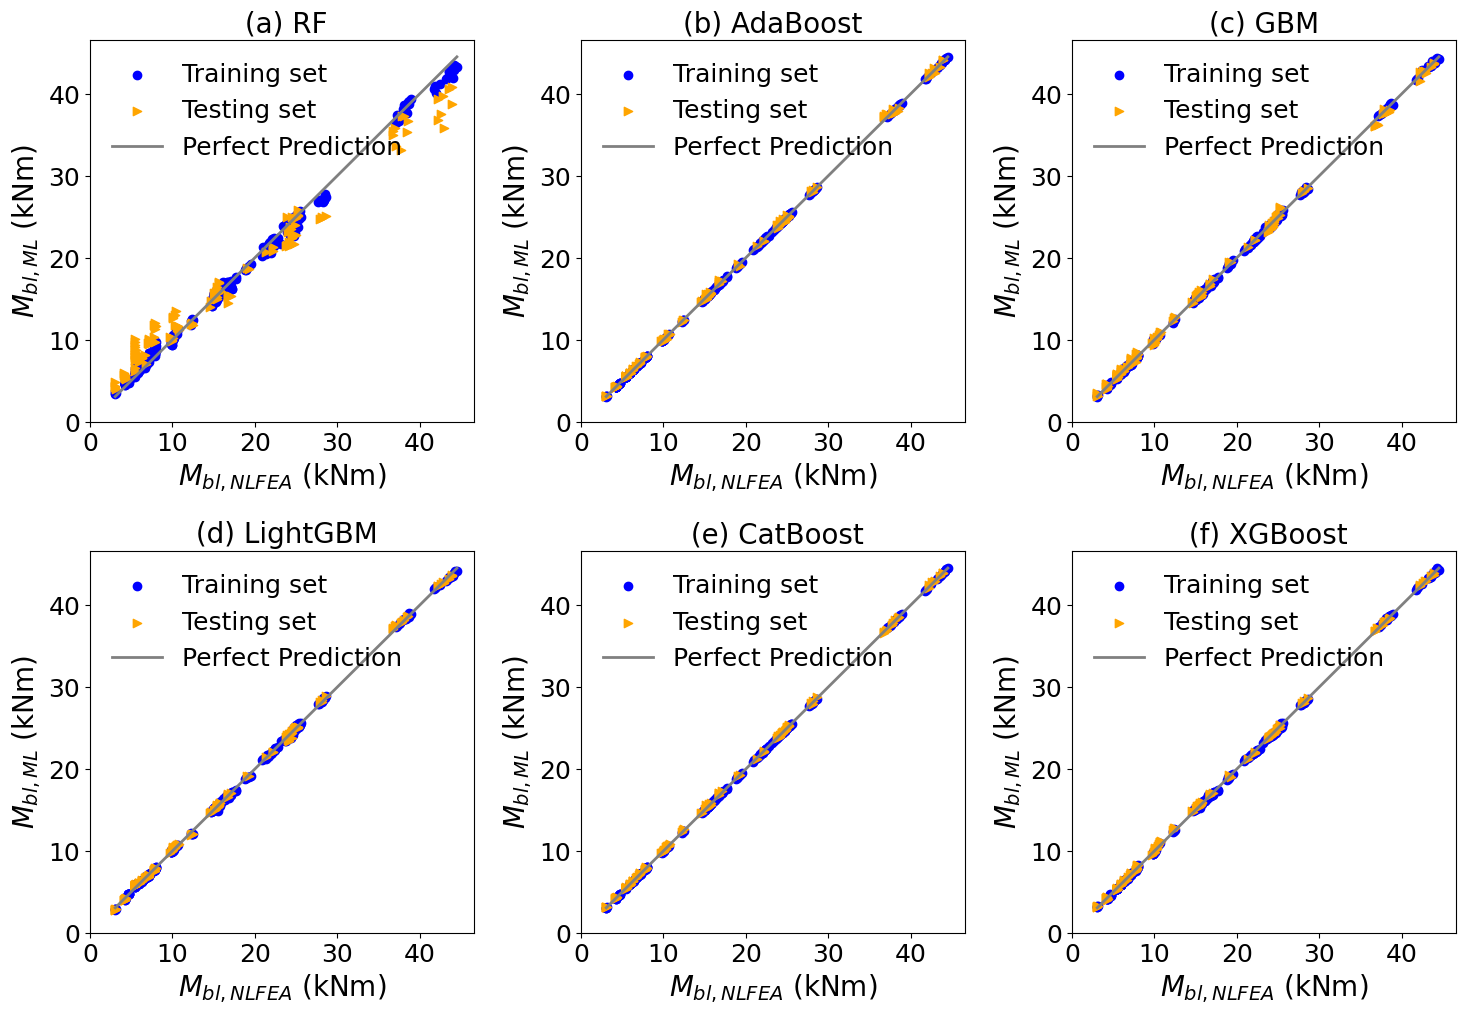

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 18})

def plot_predictions(ax, y_train, y_train_pred, y_test, y_test_pred, title):
    # Training data in blue
    ax.scatter(y_train, y_train_pred, c='blue', marker='o', label='Training set')
    
    # Testing data in magenta
    ax.scatter(y_test, y_test_pred, c='orange', marker='>', label='Testing set')
    
    # Perfect predictions line
    ax.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='gray', linestyle='-', linewidth=2, label='Perfect Prediction')
    
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(r'$M_{bl,NLFEA}$ (kNm)')
    ax.set_ylabel(r'$M_{bl,ML}$ (kNm)')

    ax.legend(loc='upper left', frameon=False)
    ax.grid(0)
    # Set font size for x-axis tick labels


  # Explicitly set the font sizes
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    
     # Set minimum limit for x and y-axis to zero
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)


# RF
rf_y_train_pred = rf.predict(X_train)
rf_y_test_pred = rf.predict(X_test)

# AdaBoost
ada_y_train_pred = ada.predict(X_train)
ada_y_test_pred = ada.predict(X_test)

# GBM
gbm_y_train_pred = gbm.predict(X_train)
gbm_y_test_pred = gbm.predict(X_test)

# LightGBM
lgbm_y_train_pred = lgbm.predict(X_train)
lgbm_y_test_pred = lgbm.predict(X_test)

# CatBoost
catboost_y_train_pred = cat.predict(X_train)
catboost_y_test_pred = cat.predict(X_test)

# XGBoost
xgb_y_train_pred = xgb.predict(X_train)
xgb_y_test_pred =xgb.predict(X_test)


# Create a 4x3 grid for plotting
fig, axs = plt.subplots(4, 3, figsize=(15, 20))
models = [" (a) RF", "(b) AdaBoost", "(c) GBM", " (d) LightGBM", " (e) CatBoost", " (f) XGBoost"]
predictions = [
    (rf_y_train_pred, rf_y_test_pred),
    (ada_y_train_pred, ada_y_test_pred),
    (gbm_y_train_pred, gbm_y_test_pred),
    (lgbm_y_train_pred, lgbm_y_test_pred),
    (catboost_y_train_pred, catboost_y_test_pred),
    (xgb_y_train_pred, xgb_y_test_pred)
]

# Plot predictions for each model
for ax, (y_train_pred, y_test_pred), title in zip(axs.ravel(), predictions, models):
    plot_predictions(ax, y_train, y_train_pred, y_test, y_test_pred, title)
   # Remove any unused subplots
for i in range(len(models), 12):
    fig.delaxes(axs.ravel()[i])

plt.tight_layout()
plt.savefig('figs/parity3x2.pdf', bbox_inches='tight')



In [34]:
# === AISI S100 Section 8 calibration (LRFD ϕ and ASD Ω) ===
# Place this entire cell BELOW your plotting cell. It uses your existing variables:
#   y_train, y_test, and the *_y_test_pred arrays for RF, AdaBoost, GBM, LightGBM, CatBoost, XGBoost.
# It computes "model error" as NLFEA-to-prediction ratio on the TEST SET and calibrates ϕ and Ω.

import numpy as np
import pandas as pd
from math import sqrt, exp

# -----------------------------
# Helper functions and settings
# -----------------------------
def model_error_stats(y_true: np.ndarray, y_pred: np.ndarray, n_override: int = None):
    """
    Compute model error statistics with the convention:
        model_error_i = y_true_i / y_pred_i = (NLFEA) / (Prediction)
    Returns a dict with mean (P_m), coefficient of variation (V_P), n,
    max error (%) = 100 * max |1 - ratio|, RMSE (kNm), and MAPE (%).
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape.")
    if np.any(y_pred == 0.0):
        raise ValueError("Predictions contain zeros; cannot form NLFEA/prediction ratio.")

    ratio = y_true / y_pred
    n = int(len(ratio)) if n_override is None else int(n_override)
    P_m = float(np.mean(ratio))
    V_P = float(np.std(ratio, ddof=1) / P_m) if len(ratio) > 1 else 0.0

    # Additional diagnostics (not directly used in calibration but useful for reporting)
    max_error_pct = float(100.0 * np.max(np.abs(1.0 - ratio)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    mape = float(100.0 * np.mean(np.abs((y_true - y_pred) / y_true)))

    return {
        "P_m": P_m,
        "V_P": V_P,
        "n": n,
        "max_error_pct": max_error_pct,
        "RMSE": rmse,
        "MAPE": mape,
    }

def correction_factor_Cp(n: int) -> float:
    """
    Small-sample correction factor (AISI Section 8):
        C_P = (1 + 1/n)^(m/(m-2)), with m = n - 1
    """
    if n <= 3:
        # For very small n, return a very conservative large factor.
        return float("inf")
    m = n - 1
    return (1.0 + 1.0 / n) ** (m / (m - 2))

def calibrate_phi_omega(
    P_m: float,
    V_P: float,
    n: int,
    *,
    # --- AISI S100 inputs (set for your limit state; defaults shown are placeholders) ---
    C_phi: float = 1.52,   # LRFD calibration coefficient
    beta_o: float = 2.5,   # Target reliability index for CFS members
    M_m: float = 1.10,     # Mean material factor
    V_M: float = 0.10,     # COV of material factor
    F_m: float = 1.00,     # Mean fabrication factor
    V_F: float = 0.05,     # COV of fabrication factor
    V_Q: float = 0.21,     # COV of load effect (LRFD load combo; confirm for bending)
    V_P_min: float = 0.065 # Minimum COV floor on model error per AISI
):
    """
    AISI S100 Section 8 (Eqs. 18–19):
        ϕ = Cϕ * (Mm * Fm * Pm) * exp( - βo * sqrt(VM^2 + VF^2 + C_P * VP^2 + VQ^2) )
        Ω = 1.6 / ϕ
    Notes:
      - VP is floored at V_P_min.
      - C_P uses the sample size n employed to estimate P_m and V_P.
    """
    C_P = correction_factor_Cp(n)
    V_P_eff = max(V_P, V_P_min)
    sigma_ln = sqrt(V_M**2 + V_F**2 + C_P * (V_P_eff**2) + V_Q**2)

    phi = C_phi * (M_m * F_m * P_m) * exp(-beta_o * sigma_ln)
    Omega = 1.6 / phi
    return phi, Omega, {"C_P": C_P, "V_P_eff": V_P_eff, "sigma_ln": sigma_ln}

# -------------------------------------------------
# Collect predictions and compute per-model results
# -------------------------------------------------

# Choose the effective n used in the small-sample correction:
# If you want to use the TEST SET size, leave as None.
# If you want to use the FULL DATASET size (e.g., 432 from your abstract), set OVERRIDE_N = 432.
OVERRIDE_N = 432  # or set to 432

# Map model display names to your existing TEST predictions
model_preds = {
    "Random Forest Regressor (RF)": rf_y_test_pred,
    "Adaptive Boosting Regressor (AdaBoost)": ada_y_test_pred,
    "Gradient Boosting Regressor (GBR)": gbm_y_test_pred,
    "Light Gradient Boosting Machine (LightGBM)": lgbm_y_test_pred,
    "Categorical Boosting (CatBoost)": catboost_y_test_pred,
    "Extreme Gradient Boosting (XGBoost)": xgb_y_test_pred,
}

# AISI inputs (CONFIRM/ADJUST for local-buckling bending M_bl)
AISI_INPUTS = dict(
    C_phi=1.52,   # TODO: confirm for bending in your code base
    beta_o=2.5,   # common for CFS members
    M_m=1.10,     # TODO: confirm for bending
    V_M=0.10,     # TODO: confirm for bending
    F_m=1.00,
    V_F=0.05,
    V_Q=0.21,     # LRFD load effect COV for your load combination (confirm)
    V_P_min=0.065
)

rows = []
for name, y_pred in model_preds.items():
    stats = model_error_stats(y_test, y_pred, n_override=OVERRIDE_N)
    phi, Omega, extras = calibrate_phi_omega(
        stats["P_m"], stats["V_P"], stats["n"], **AISI_INPUTS
    )
    rows.append({
        "Model": name,
        # Model error characteristics (NLFEA-to-prediction ratio)
        "P_m (mean ratio)": stats["P_m"],
        "V_P (COV)": stats["V_P"],
        "n_used": stats["n"],
        "phi (LRFD)": phi,
        "Omega (ASD)": Omega,
        # Internals
        "C_P": extras["C_P"],
        "V_P_eff (with floor)": extras["V_P_eff"],
        "sigma_ln": extras["sigma_ln"],
    })

results_df = pd.DataFrame(rows).sort_values(by="phi (LRFD)", ascending=False)
pd.set_option("display.precision", 4)
print(results_df.to_string(index=False))

# Optionally save
results_df.to_csv("results/AISI_S100_Section8_calibration_results.csv", index=False)


                                     Model  P_m (mean ratio)  V_P (COV)  n_used  phi (LRFD)  Omega (ASD)    C_P  V_P_eff (with floor)  sigma_ln
    Adaptive Boosting Regressor (AdaBoost)            1.0004     0.0097     432      0.9028       1.7722 1.0023                0.0650    0.2466
Light Gradient Boosting Machine (LightGBM)            1.0000     0.0266     432      0.9025       1.7728 1.0023                0.0650    0.2466
       Extreme Gradient Boosting (XGBoost)            0.9983     0.0194     432      0.9010       1.7759 1.0023                0.0650    0.2466
           Categorical Boosting (CatBoost)            0.9982     0.0098     432      0.9009       1.7761 1.0023                0.0650    0.2466
         Gradient Boosting Regressor (GBR)            0.9947     0.0333     432      0.8977       1.7824 1.0023                0.0650    0.2466
              Random Forest Regressor (RF)            0.9155     0.1815     432      0.7243       2.2092 1.0023                0.1815   

In [35]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Define a function to compute MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

models = [ rf, ada, gbm, lgbm,cat, xgb ]
model_names = ["RF", "AdaBoost", "GBM", "LightGBM", "CatBoost", "XGBoost" ]

metrics = {'(a) ' + r'$R^2$': [], '(b) RMSE (kNm)': [], '(c) MAE (kNm)': [], '(d)  MAPE'+r'$(\%)$': []}

for model in models:
    # Predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # R2
    metrics['(a) ' + r'$R^2$'].append((r2_score(y_train, train_preds), r2_score(y_test, test_preds)))
    
    # RMSE
    metrics['(b) RMSE (kNm)'].append((np.sqrt(mean_squared_error(y_train, train_preds)), np.sqrt(mean_squared_error(y_test, test_preds))))
    
    # MAE
    metrics['(c) MAE (kNm)'].append((mean_absolute_error(y_train, train_preds), mean_absolute_error(y_test, test_preds)))
    
    # MAPE
    metrics['(d)  MAPE'+r'$(\%)$'].append((mean_absolute_percentage_error(y_train, train_preds), mean_absolute_percentage_error(y_test, test_preds)))


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


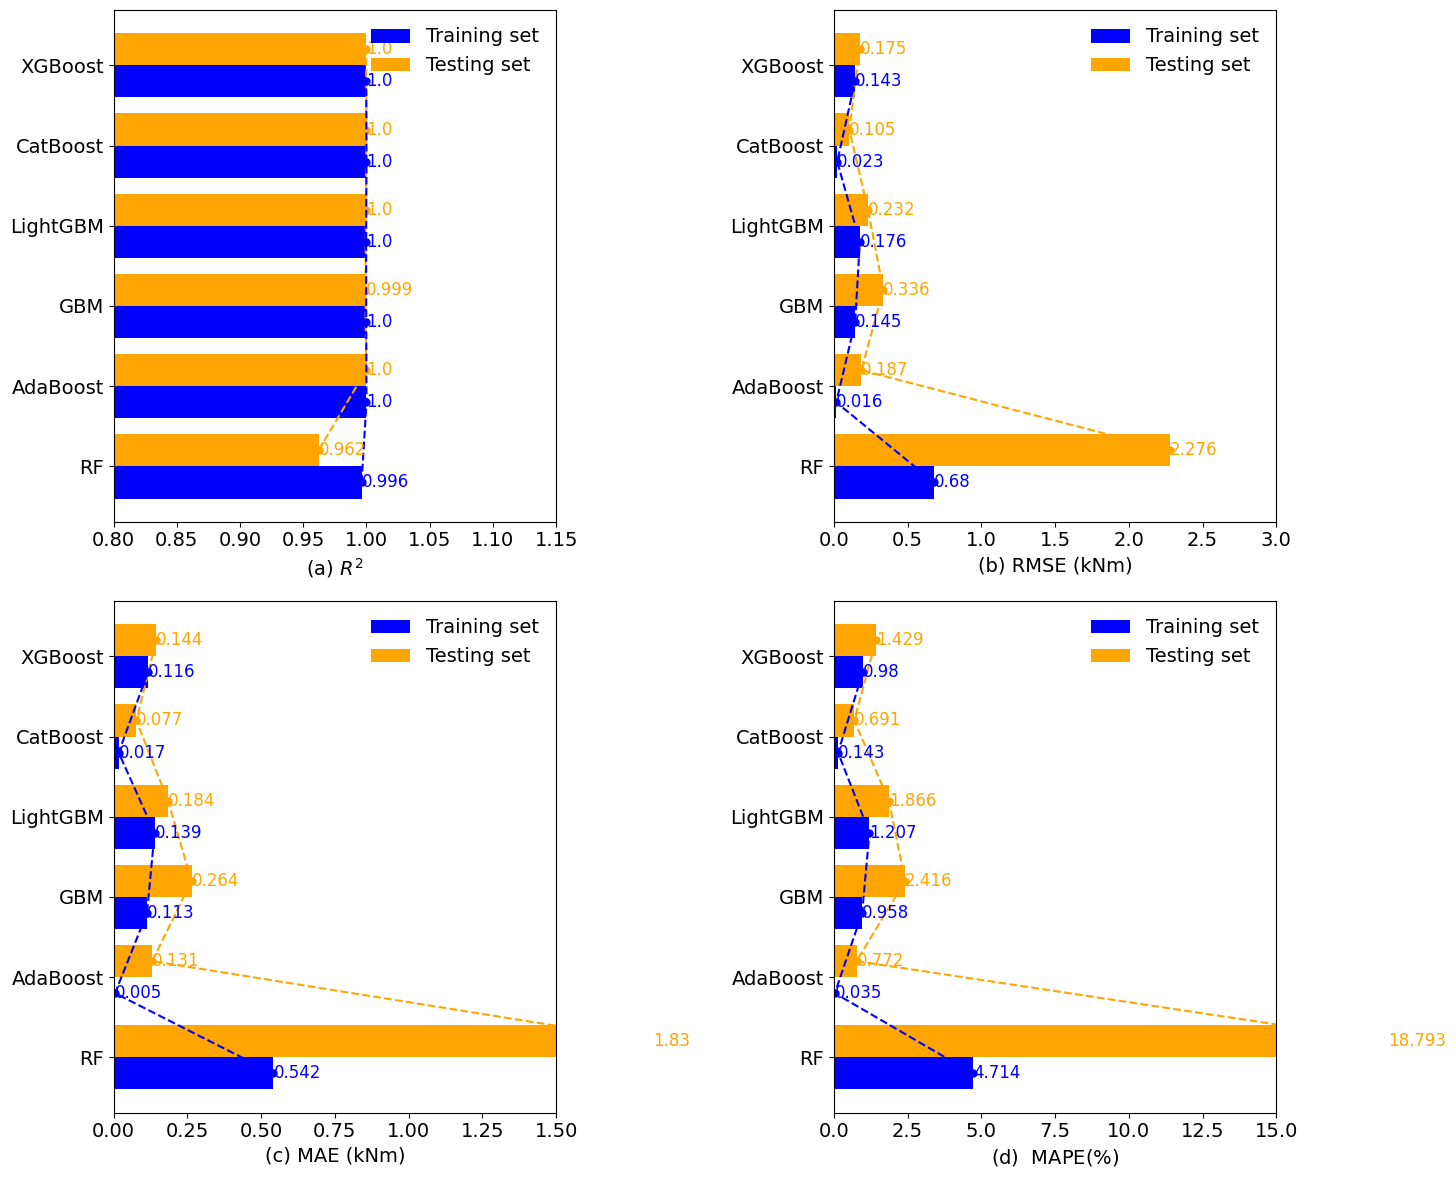

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})
# Define the function to plot metrics in a 2x2 grid
def plot_metrics_2x2(metrics):
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    metric_names = [ '(a) ' + r'$R^2$', '(b) RMSE (kNm)', '(c) MAE (kNm)', '(d)  MAPE'+r'$(\%)$']
    colors = ['blue', 'orange']

    bar_width = 0.4
    index = np.arange(len(model_names))
    
    custom_ticks1 = [0.8, 0.85, 0.90, 0.95, 1.0, 1.05, 1.10, 1.15]
    custom_ticks2 = [0, 0.5, 1, 1.5, 2, 2.5, 3]
    custom_ticks3 = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
    custom_ticks4 = [0, 2.5, 5, 7.5, 10,12.5, 15]
    custom_ticks_all = [custom_ticks1, custom_ticks2, custom_ticks3, custom_ticks4]
    
    for idx, (ax, metric) in enumerate(zip(axs.ravel(), metric_names)):
        # Training results
        train_results = [item[0] for item in metrics[metric]]
        bars1 = ax.barh(index, train_results, bar_width, color=colors[0], align='center', label='Training set')
        ax.set_xticks(custom_ticks_all[idx])
        ax.set_xlim([min(custom_ticks_all[idx]), max(custom_ticks_all[idx])])  # Set the x-limit using custom ticks
        # Adding numbers on top of bars
        for bar in bars1:
            yval = bar.get_width()
            ax.text(yval, bar.get_y() + bar.get_height()/2, round(yval, 3), va='center', ha='left',color=colors[0], fontsize=12)

        # Testing results
        test_results = [item[1] for item in metrics[metric]]
        bars2 = ax.barh(index + bar_width, test_results, bar_width, color=colors[1], align='center', label='Testing set')
        # Adding numbers on top of bars
        for bar in bars2:
            yval = bar.get_width()
            ax.text(yval, bar.get_y() + bar.get_height()/2, round(yval, 3), va='center', ha='left',color=colors[1], fontsize=12) 
        # Dotted trendline
        ax.plot(test_results, index + bar_width, 'o--', color=colors[1], markersize=5)
        ax.plot(train_results, index, 'o--', color=colors[0], markersize=5)

        ax.set_xlabel(metric)
        ax.set_yticks(index + bar_width / 2)
        ax.set_yticklabels(model_names)
        ax.legend(loc='upper right', frameon=False)

    plt.tight_layout()
    plt.savefig('figs/metrics2x2.pdf', bbox_inches='tight')
    #plt.show()

# Plot all metrics in a 2x2 grid
plot_metrics_2x2(metrics)


# 4. COMPARISON WITH ANALYTICAL MODELS

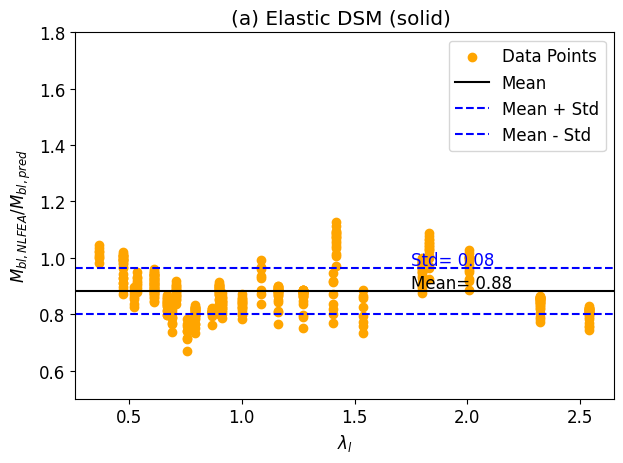

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 12})
# Load the data from Excel file
file_path = 'datasets/data_DSM_solid_1.xlsx'
df = pd.read_excel(file_path)

# Plot the scatter plot

plt.scatter(df['lambda_d'], df['theta'], label='Data Points', color='orange')
plt.xlabel(r'$\lambda_l$')
plt.ylabel('$M_{bl,NLFEA}/M_{bl,pred}$')
plt.title('(a) Elastic DSM (solid) ')

# Compute mean and STD of theta
mean_theta = np.mean(df['theta'])
std_theta = np.std(df['theta'])

# Plot horizontal lines at y=mean, y=mean+STD, and y=mean-STD
plt.axhline(mean_theta, color='black', linestyle='-', label='Mean')
plt.axhline(mean_theta + std_theta, color='b', linestyle='--', label='Mean + Std')
plt.axhline(mean_theta - std_theta, color='b', linestyle='--', label='Mean - Std')

# Show the values of mean and STD on the graph
plt.text(1.75, mean_theta+0.01, f'Mean= {mean_theta:.2f}', color='black')
plt.text(1.75, mean_theta + std_theta+0.01, f'Std= {std_theta:.2f}', color='b')
#plt.text(0.5, mean_theta - std_theta, f'Mean - STD: {mean_theta - std_theta:.2f}', color='g')
plt.ylim(0.5, 1.8) 
# Show legend
plt.legend()
plt.tight_layout()
plt.savefig('figs/Figure7a.pdf', bbox_inches='tight')
# Display the plot
plt.show()


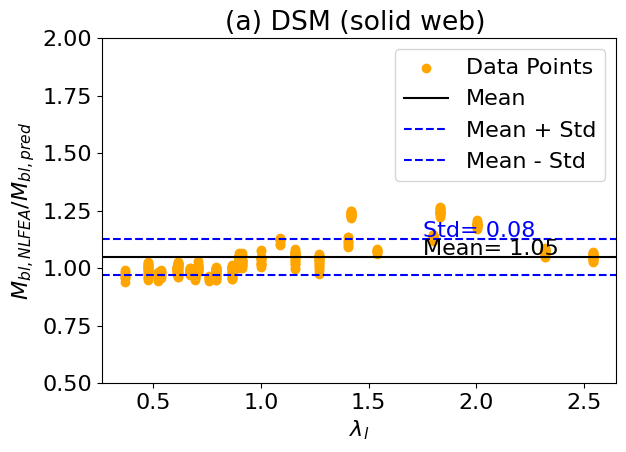

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 16})
# Load the data from Excel file
file_path = 'datasets/data_DSM_solids.xlsx'
df = pd.read_excel(file_path)

# Plot the scatter plot

plt.scatter(df['lambda_d'], df['theta'], label='Data Points', color='orange')
plt.xlabel(r'$\lambda_l$')
plt.ylabel('$M_{bl,NLFEA}/M_{bl,pred}$')
plt.title('(a) DSM (solid web) ')

# Compute mean and STD of theta
mean_theta = np.mean(df['theta'])
std_theta = np.std(df['theta'])

# Plot horizontal lines at y=mean, y=mean+STD, and y=mean-STD
plt.axhline(mean_theta, color='black', linestyle='-', label='Mean')
plt.axhline(mean_theta + std_theta, color='b', linestyle='--', label='Mean + Std')
plt.axhline(mean_theta - std_theta, color='b', linestyle='--', label='Mean - Std')

# Show the values of mean and STD on the graph
plt.text(1.75, mean_theta+0.01, f'Mean= {mean_theta:.2f}', color='black')
plt.text(1.75, mean_theta + std_theta+0.01, f'Std= {std_theta:.2f}', color='b')
#plt.text(0.5, mean_theta - std_theta, f'Mean - STD: {mean_theta - std_theta:.2f}', color='g')
plt.ylim(0.5, 2) 
# Show legend
plt.legend()
plt.tight_layout()
plt.savefig('figs/Figure7b.pdf', bbox_inches='tight')
# Display the plot
#plt.show()


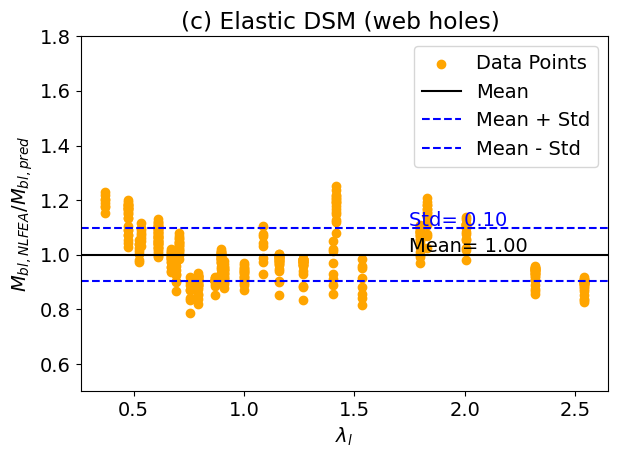

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})
# Load the data from Excel file
file_path = 'datasets/data_DSM_slot_1.xlsx'
df = pd.read_excel(file_path)

# Plot the scatter plot

plt.scatter(df['lambda_d'], df['theta'], label='Data Points', color='orange')
plt.xlabel(r'$\lambda_l$')
plt.ylabel('$M_{bl,NLFEA}/M_{bl,pred}$')
plt.title('(c) Elastic DSM (web holes) ')

# Compute mean and STD of theta
mean_theta = np.mean(df['theta'])
std_theta = np.std(df['theta'])

# Plot horizontal lines at y=mean, y=mean+STD, and y=mean-STD
plt.axhline(mean_theta, color='black', linestyle='-', label='Mean')
plt.axhline(mean_theta + std_theta, color='b', linestyle='--', label='Mean + Std')
plt.axhline(mean_theta - std_theta, color='b', linestyle='--', label='Mean - Std')

# Show the values of mean and STD on the graph
plt.text(1.75, mean_theta+0.01, f'Mean= {mean_theta:.2f}', color='black')
plt.text(1.75, mean_theta + std_theta+0.01, f'Std= {std_theta:.2f}', color='b')
#plt.text(0.5, mean_theta - std_theta, f'Mean - STD: {mean_theta - std_theta:.2f}', color='g')
plt.ylim(0.5, 1.8) 
# Show legend
plt.legend()
plt.tight_layout()
plt.savefig('figs/Figure7c.pdf', bbox_inches='tight')
# Display the plot
plt.show()


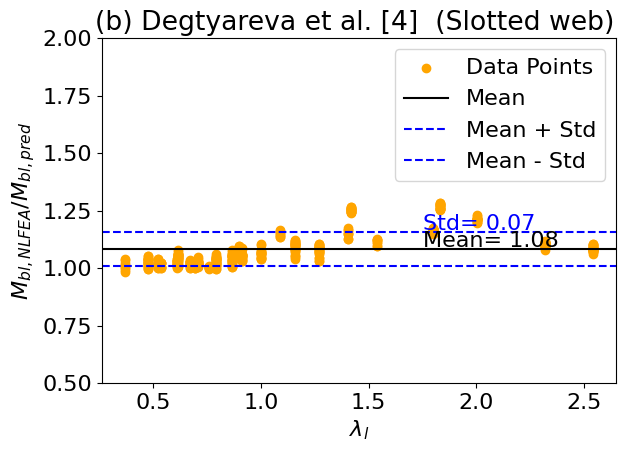

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 16})
# Load the data from Excel file
file_path = 'datasets/data_DSM_slots.xlsx'
df = pd.read_excel(file_path)

# Plot the scatter plot

plt.scatter(df['lambda_d'], df['theta'], label='Data Points', color='orange')
plt.xlabel(r'$\lambda_l$')
plt.ylabel('$M_{bl,NLFEA}/M_{bl,pred}$')
plt.title('(b) Degtyareva et al. [4]  (Slotted web) ')

# Compute mean and STD of theta
mean_theta = np.mean(df['theta'])
std_theta = np.std(df['theta'])

# Plot horizontal lines at y=mean, y=mean+STD, and y=mean-STD
plt.axhline(mean_theta, color='black', linestyle='-', label='Mean')
plt.axhline(mean_theta + std_theta, color='b', linestyle='--', label='Mean + Std')
plt.axhline(mean_theta - std_theta, color='b', linestyle='--', label='Mean - Std')

# Show the values of mean and STD on the graph
plt.text(1.75, mean_theta+0.01, f'Mean= {mean_theta:.2f}', color='black')
plt.text(1.75, mean_theta + std_theta+0.01, f'Std= {std_theta:.2f}', color='b')
#plt.text(0.5, mean_theta - std_theta, f'Mean - STD: {mean_theta - std_theta:.2f}', color='g')
plt.ylim(0.5, 2) 
# Show legend
plt.legend()
plt.tight_layout()
plt.savefig('figs/Figure7d.pdf', bbox_inches='tight')
# Display the plot
plt.show()


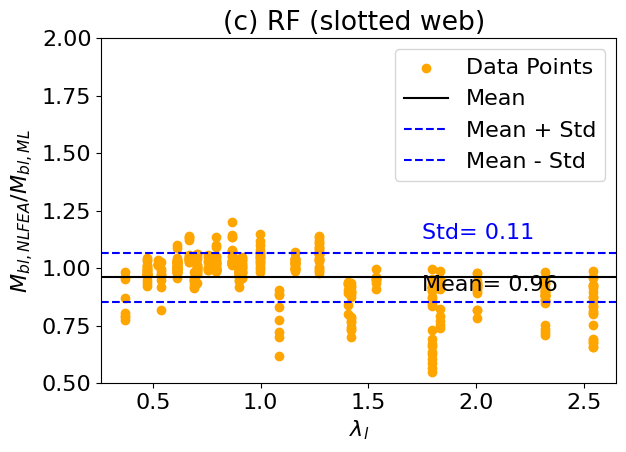

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# XGBoost

# Load data from the Excel file
df1 = pd.read_excel('datasets/Data.xlsx', engine='openpyxl')

# Splitting the data into features (X) and target (y)
X = df1.iloc[:, :-1].values
y = df1.iloc[:, -1].values
rf_comp = rf.predict(X)
rf_theta=y/rf_comp

plt.rcParams.update({'font.size': 16})


# Load the data from Excel file
file_path = 'datasets/data_DSM_slots.xlsx'
df = pd.read_excel(file_path)

# Plot the scatter plot

plt.scatter(df['lambda_d'],rf_theta, label='Data Points', color='orange')
plt.xlabel(r'$\lambda_l$')
plt.ylabel('$M_{bl,NLFEA}/M_{bl,ML}$')
plt.title('(c) RF (slotted web) ')

# Compute mean and STD of theta
mean_theta = np.mean(rf_theta)
std_theta = np.std(rf_theta)

# Plot horizontal lines at y=mean, y=mean+STD, and y=mean-STD
plt.axhline(mean_theta, color='black', linestyle='-', label='Mean')
plt.axhline(mean_theta + std_theta, color='b', linestyle='--', label='Mean + Std')
plt.axhline(mean_theta - std_theta, color='b', linestyle='--', label='Mean - Std')

# Show the values of mean and STD on the graph
plt.text(1.75, mean_theta-0.06, f'Mean= {mean_theta:.2f}', color='black')
plt.text(1.75, mean_theta + std_theta+0.06, f'Std= {std_theta:.2f}', color='b')
#plt.text(0.5, mean_theta - std_theta, f'Mean - STD: {mean_theta - std_theta:.2f}', color='g')
plt.ylim(0.5, 2) 
# Show legend
plt.legend()
plt.tight_layout()
plt.savefig('figs/Figure7e.pdf', bbox_inches='tight')
# Display the plot
plt.show()



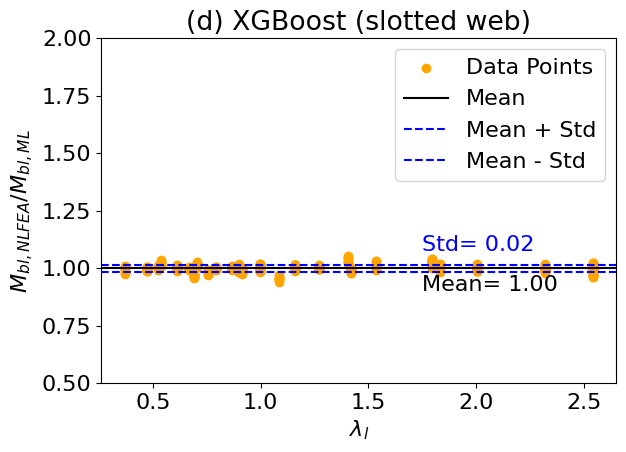

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# XGBoost

# Load data from the Excel file
df1 = pd.read_excel('datasets/Data.xlsx', engine='openpyxl')

# Splitting the data into features (X) and target (y)
X = df1.iloc[:, :-1].values
y = df1.iloc[:, -1].values
xgb_comp = xgb.predict(X)
xgb_theta=y/xgb_comp

plt.rcParams.update({'font.size': 16})


# Load the data from Excel file
file_path = 'datasets/data_DSM_slots.xlsx'
df = pd.read_excel(file_path)

# Plot the scatter plot

plt.scatter(df['lambda_d'],xgb_theta, label='Data Points', color='orange')
plt.xlabel(r'$\lambda_l$')
plt.ylabel('$M_{bl,NLFEA}/M_{bl,ML}$')
plt.title('(d) XGBoost (slotted web)')

# Compute mean and STD of theta
mean_theta = np.mean(xgb_theta)
std_theta = np.std(xgb_theta)

# Plot horizontal lines at y=mean, y=mean+STD, and y=mean-STD
plt.axhline(mean_theta, color='black', linestyle='-', label='Mean')
plt.axhline(mean_theta + std_theta, color='b', linestyle='--', label='Mean + Std')
plt.axhline(mean_theta - std_theta, color='b', linestyle='--', label='Mean - Std')

# Show the values of mean and STD on the graph
plt.text(1.75, mean_theta-0.1, f'Mean= {mean_theta:.2f}', color='black')
plt.text(1.75, mean_theta + std_theta+0.06, f'Std= {std_theta:.2f}', color='b')
#plt.text(0.5, mean_theta - std_theta, f'Mean - STD: {mean_theta - std_theta:.2f}', color='g')
plt.ylim(0.5, 2) 
# Show legend
plt.legend()
plt.tight_layout()
plt.savefig('figs/Figure7f.pdf', bbox_inches='tight')
# Display the plot
plt.show()



In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# XGBoost

# Load data from the Excel file
df1 = pd.read_excel('datasets/Data.xlsx', engine='openpyxl')

# Assuming xgb_model is already defined and trained
xgb_comp = xgb.predict(df1.iloc[:, :-1].values)
xgb_theta = df1.iloc[:, -1].values / xgb_comp

# Compute statistics of xgb_theta
min_xgb_theta = np.min(xgb_theta)
max_xgb_theta = np.max(xgb_theta)
mean_xgb_theta = np.mean(xgb_theta)
std_xgb_theta = np.std(xgb_theta)
cov_xgb_theta = std_xgb_theta / mean_xgb_theta*100  # Coefficient of Variation in percentage

# Display the statistics in a table
statistics_table = pd.DataFrame({
    'Min': [min_xgb_theta],
    'Max': [max_xgb_theta],
    'Mean': [mean_xgb_theta],
    'Std': [std_xgb_theta],
    'COV': [cov_xgb_theta]
})

print("Statistics of xgb_theta:")
print(statistics_table)


Statistics of xgb_theta:
      Min     Max    Mean     Std     COV
0  0.9405  1.0528  0.9997  0.0155  1.5458


In [45]:
import numpy as np
from catboost import CatBoostRegressor

# Load data from the Excel file
df1 = pd.read_excel('datasets/Data.xlsx', engine='openpyxl')

# Assuming cat_model is already defined and trained
cat_comp = rf.predict(df1.iloc[:, :-1].values)
cat_theta = df1.iloc[:, -1].values / cat_comp

# Compute statistics of cat_theta
min_cat_theta = np.min(cat_theta)
max_cat_theta = np.max(cat_theta)
mean_cat_theta = np.mean(cat_theta)
std_cat_theta = np.std(cat_theta)
cov_cat_theta = std_cat_theta / mean_cat_theta * 100  # Coefficient of Variation in percentage

# Display the statistics in a table
statistics_table_cat = pd.DataFrame({
    'Min': [min_cat_theta],
    'Max': [max_cat_theta],
    'Mean': [mean_cat_theta],
    'Std': [std_cat_theta],
    'COV': [cov_cat_theta]
})

print("Statistics of cat_theta:")
print(statistics_table_cat)

Statistics of cat_theta:
      Min     Max    Mean     Std      COV
0  0.5468  1.2008  0.9599  0.1058  11.0179


# 5.0 SHAP AND PDP PLOTS

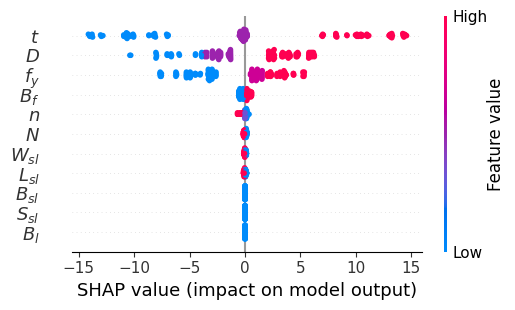

<Figure size 640x480 with 0 Axes>

In [49]:
import shap
import matplotlib.pyplot as plt

# ... [Your existing code]
plt.rcParams.update({'font.size': 100})

tex_labels = [
    "$D$", "$B_f$", "$B_l$", "$t$", "$L_{sl}$", "$W_{sl}$", 
    "$S_{sl}$", "$B_{sl}$", "$N$", "$n$", "$f_y$", "$M$"
]

# Function to generate a custom summary plot for each model and save to a PDF
def generate_and_save_shap_plot(explainer, model_data, feature_names, model_name):
    shap_values = explainer.shap_values(model_data)
    shap.summary_plot(shap_values, model_data, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(f"shap_plot_{model_name}.pdf", format="pdf", dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()


# XGBoost
explainer_xgb = shap.TreeExplainer(xgb)
generate_and_save_shap_plot(explainer_xgb, X_test, tex_labels, "xgboost")

plt.tight_layout()
plt.savefig("figs/shap_values_xgboost.pdf", format="pdf", dpi=300)
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\486624363.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)


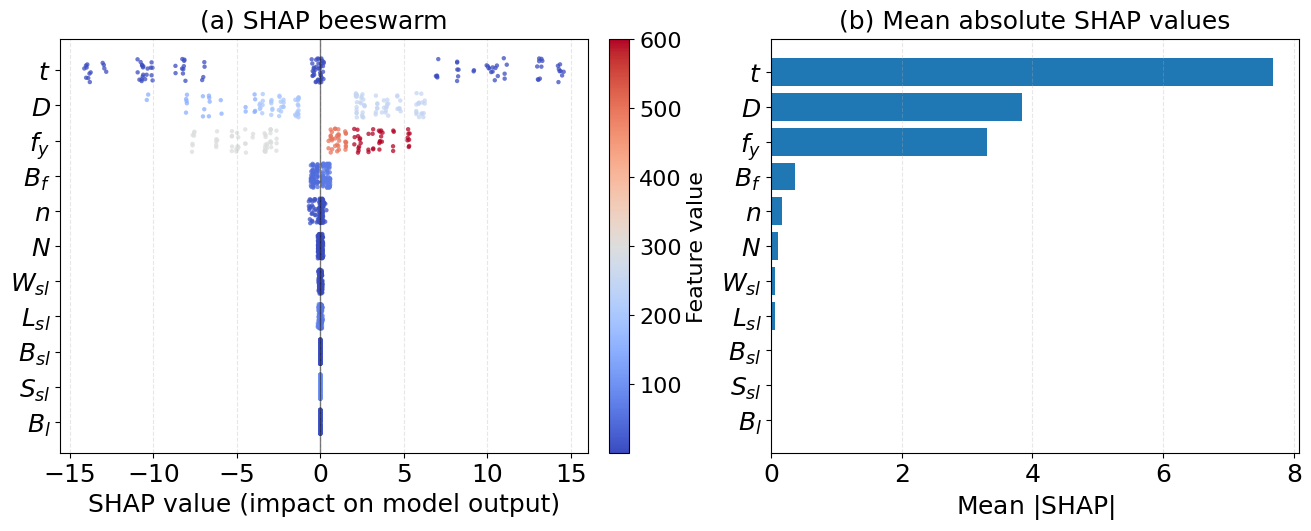

Saved: figs/shap_combo_1x2.pdf


In [50]:
"""
SHAP 1×2 figure with sane font sizes:
 (a) SHAP beeswarm
 (b) Mean |SHAP| bars

Requires:
- trained model `xgb`
- test data `X_test` (NumPy array or DataFrame)

Output: 'shap_combo_1x2.pdf'
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap

# ---------- Reset any global style overrides (fixes huge ticks) ----------
plt.rcdefaults()
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 26,
    "ytick.labelsize": 26,
})

np.random.seed(0)

# ---------- Build TeX labels aligned to feature count ----------
tex_labels_all = [
    r"$D$", r"$B_f$", r"$B_l$", r"$t$", r"$L_{sl}$", r"$W_{sl}$",
    r"$S_{sl}$", r"$B_{sl}$", r"$N$", r"$n$", r"$f_y$", r"$M$"
]

# Wrap X_test in a DataFrame with TeX labels
if isinstance(X_test, pd.DataFrame):
    n_features = X_test.shape[1]
    feature_names = tex_labels_all[:n_features]
    X_df = X_test.copy()
    if X_df.shape[1] == len(feature_names):
        X_df.columns = feature_names
else:
    n_features = X_test.shape[1]
    feature_names = tex_labels_all[:n_features]
    X_df = pd.DataFrame(X_test, columns=feature_names)

# ---------- Compute SHAP values ----------
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_df)
if isinstance(shap_values, list):  # multiclass → pick class 0 by default
    shap_values = shap_values[0]
shap_values = np.asarray(shap_values)  # (n_samples, n_features)

# Rank features by mean |SHAP|
mean_abs = np.mean(np.abs(shap_values), axis=0)
order = np.argsort(mean_abs)[::-1]
max_display = min(20, n_features)
order = order[:max_display]

# ---------- Figure ----------
fig, (ax_a, ax_b) = plt.subplots(1, 2, figsize=(13, 5.2), constrained_layout=True)

# (a) Beeswarm-style scatter
def plot_beeswarm(ax, shap_vals, X_vals, names, order_idx, cmap_name="coolwarm"):
    """
    Simple beeswarm: x = SHAP value, y = feature rank with jitter,
    color = feature value (robust color scale across displayed features).
    """
    cmap = get_cmap(cmap_name)

    # Robust global color scale across displayed features
    lows, highs = [], []
    for i in order_idx:
        col = np.asarray(X_vals[:, i], dtype=float)
        lo, hi = np.percentile(col, [5, 95])
        lows.append(lo); highs.append(hi)
    lo_g, hi_g = np.min(lows), np.max(highs)
    if np.isclose(lo_g, hi_g):
        lo_g -= 1.0; hi_g += 1.0
    norm = Normalize(vmin=lo_g, vmax=hi_g)

    display_names = [names[i] for i in order_idx]
    y_positions = np.arange(len(order_idx))[::-1]  # top feature at top

    for y, f_idx in zip(y_positions, order_idx):
        svals = shap_vals[:, f_idx]
        fvals = np.asarray(X_vals[:, f_idx], dtype=float)
        jitter = (np.random.rand(svals.shape[0]) - 0.5) * 0.7
        y_j = y + jitter
        ax.scatter(svals, y_j, s=10, alpha=0.75, c=cmap(norm(fvals)), edgecolor="none")

    ax.axvline(0, color="k", linewidth=1, alpha=0.5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(display_names)
    ax.set_xlabel("SHAP value (impact on model output)")
    ax.set_title("(a) SHAP beeswarm", pad=8)
    ax.grid(True, axis="x", linestyle="--", alpha=0.3)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)

    # Colorbar with controlled tick size
    sm = ScalarMappable(norm=norm, cmap=cmap)
    cbar = ax.figure.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Feature value", fontsize=16)
    cbar.ax.tick_params(labelsize=16)

plot_beeswarm(ax_a, shap_values, X_df.values, feature_names, order)

# (b) Mean |SHAP| bars
mean_abs_ordered = mean_abs[order]
names_ordered = [feature_names[i] for i in order]
ypos = np.arange(len(order))[::-1]

ax_b.barh(ypos, mean_abs_ordered, align="center")
ax_b.set_yticks(ypos)
ax_b.set_yticklabels(names_ordered)
ax_b.set_xlabel(r"Mean $|\mathrm{SHAP}|$")
ax_b.set_title("(b) Mean absolute SHAP values", pad=8)
ax_b.grid(True, axis="x", linestyle="--", alpha=0.3)
ax_b.tick_params(axis="x", labelsize=18)  # <- fixed
ax_b.tick_params(axis="y", labelsize=18)

# Save & show
out = "figs/shap_combo_1x2.pdf"
plt.savefig(out, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {out}")


C:\Users\DELL\AppData\Local\Temp\ipykernel_21480\2404460441.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


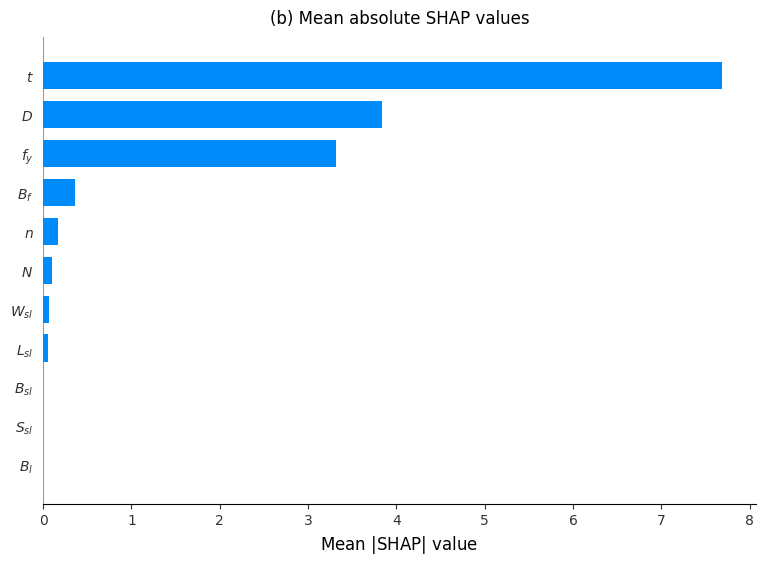

In [51]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# --- your trained model must be in `xgb`
# --- X_test must be defined (shape: [n_samples, n_features])

# 1) TeX-style labels (trim to actual feature count to avoid mismatches)
tex_labels = [
    r"$D$", r"$B_f$", r"$B_l$", r"$t$", r"$L_{sl}$", r"$W_{sl}$",
    r"$S_{sl}$", r"$B_{sl}$", r"$N$", r"$n$", r"$f_y$", r"$M$"
]
tex_labels = tex_labels[:X_test.shape[1]]

# 2) Use a DataFrame so SHAP pulls names from columns automatically
X_test_df = pd.DataFrame(X_test, columns=tex_labels)

# 3) Compute SHAP values
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_df)

# 4) Bar summary (mean |SHAP|) with a custom x-axis label
shap.summary_plot(
    shap_values,
    X_test_df,
    plot_type="bar",
    show=False,
    plot_size=(8, 6)  # optional: controls figure size
)

ax = plt.gca()
ax.set_title("(b) Mean absolute SHAP values", fontsize=12, pad=10)
ax.set_xlabel(r"Mean $|\mathrm{SHAP}|$ value ", fontsize=12)
ax.tick_params(axis="both", labelsize=10)

plt.tight_layout()
plt.savefig("figs/mean_shap_values_xgboost.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


Skipping out-of-range indices (feature count = 11): [11]


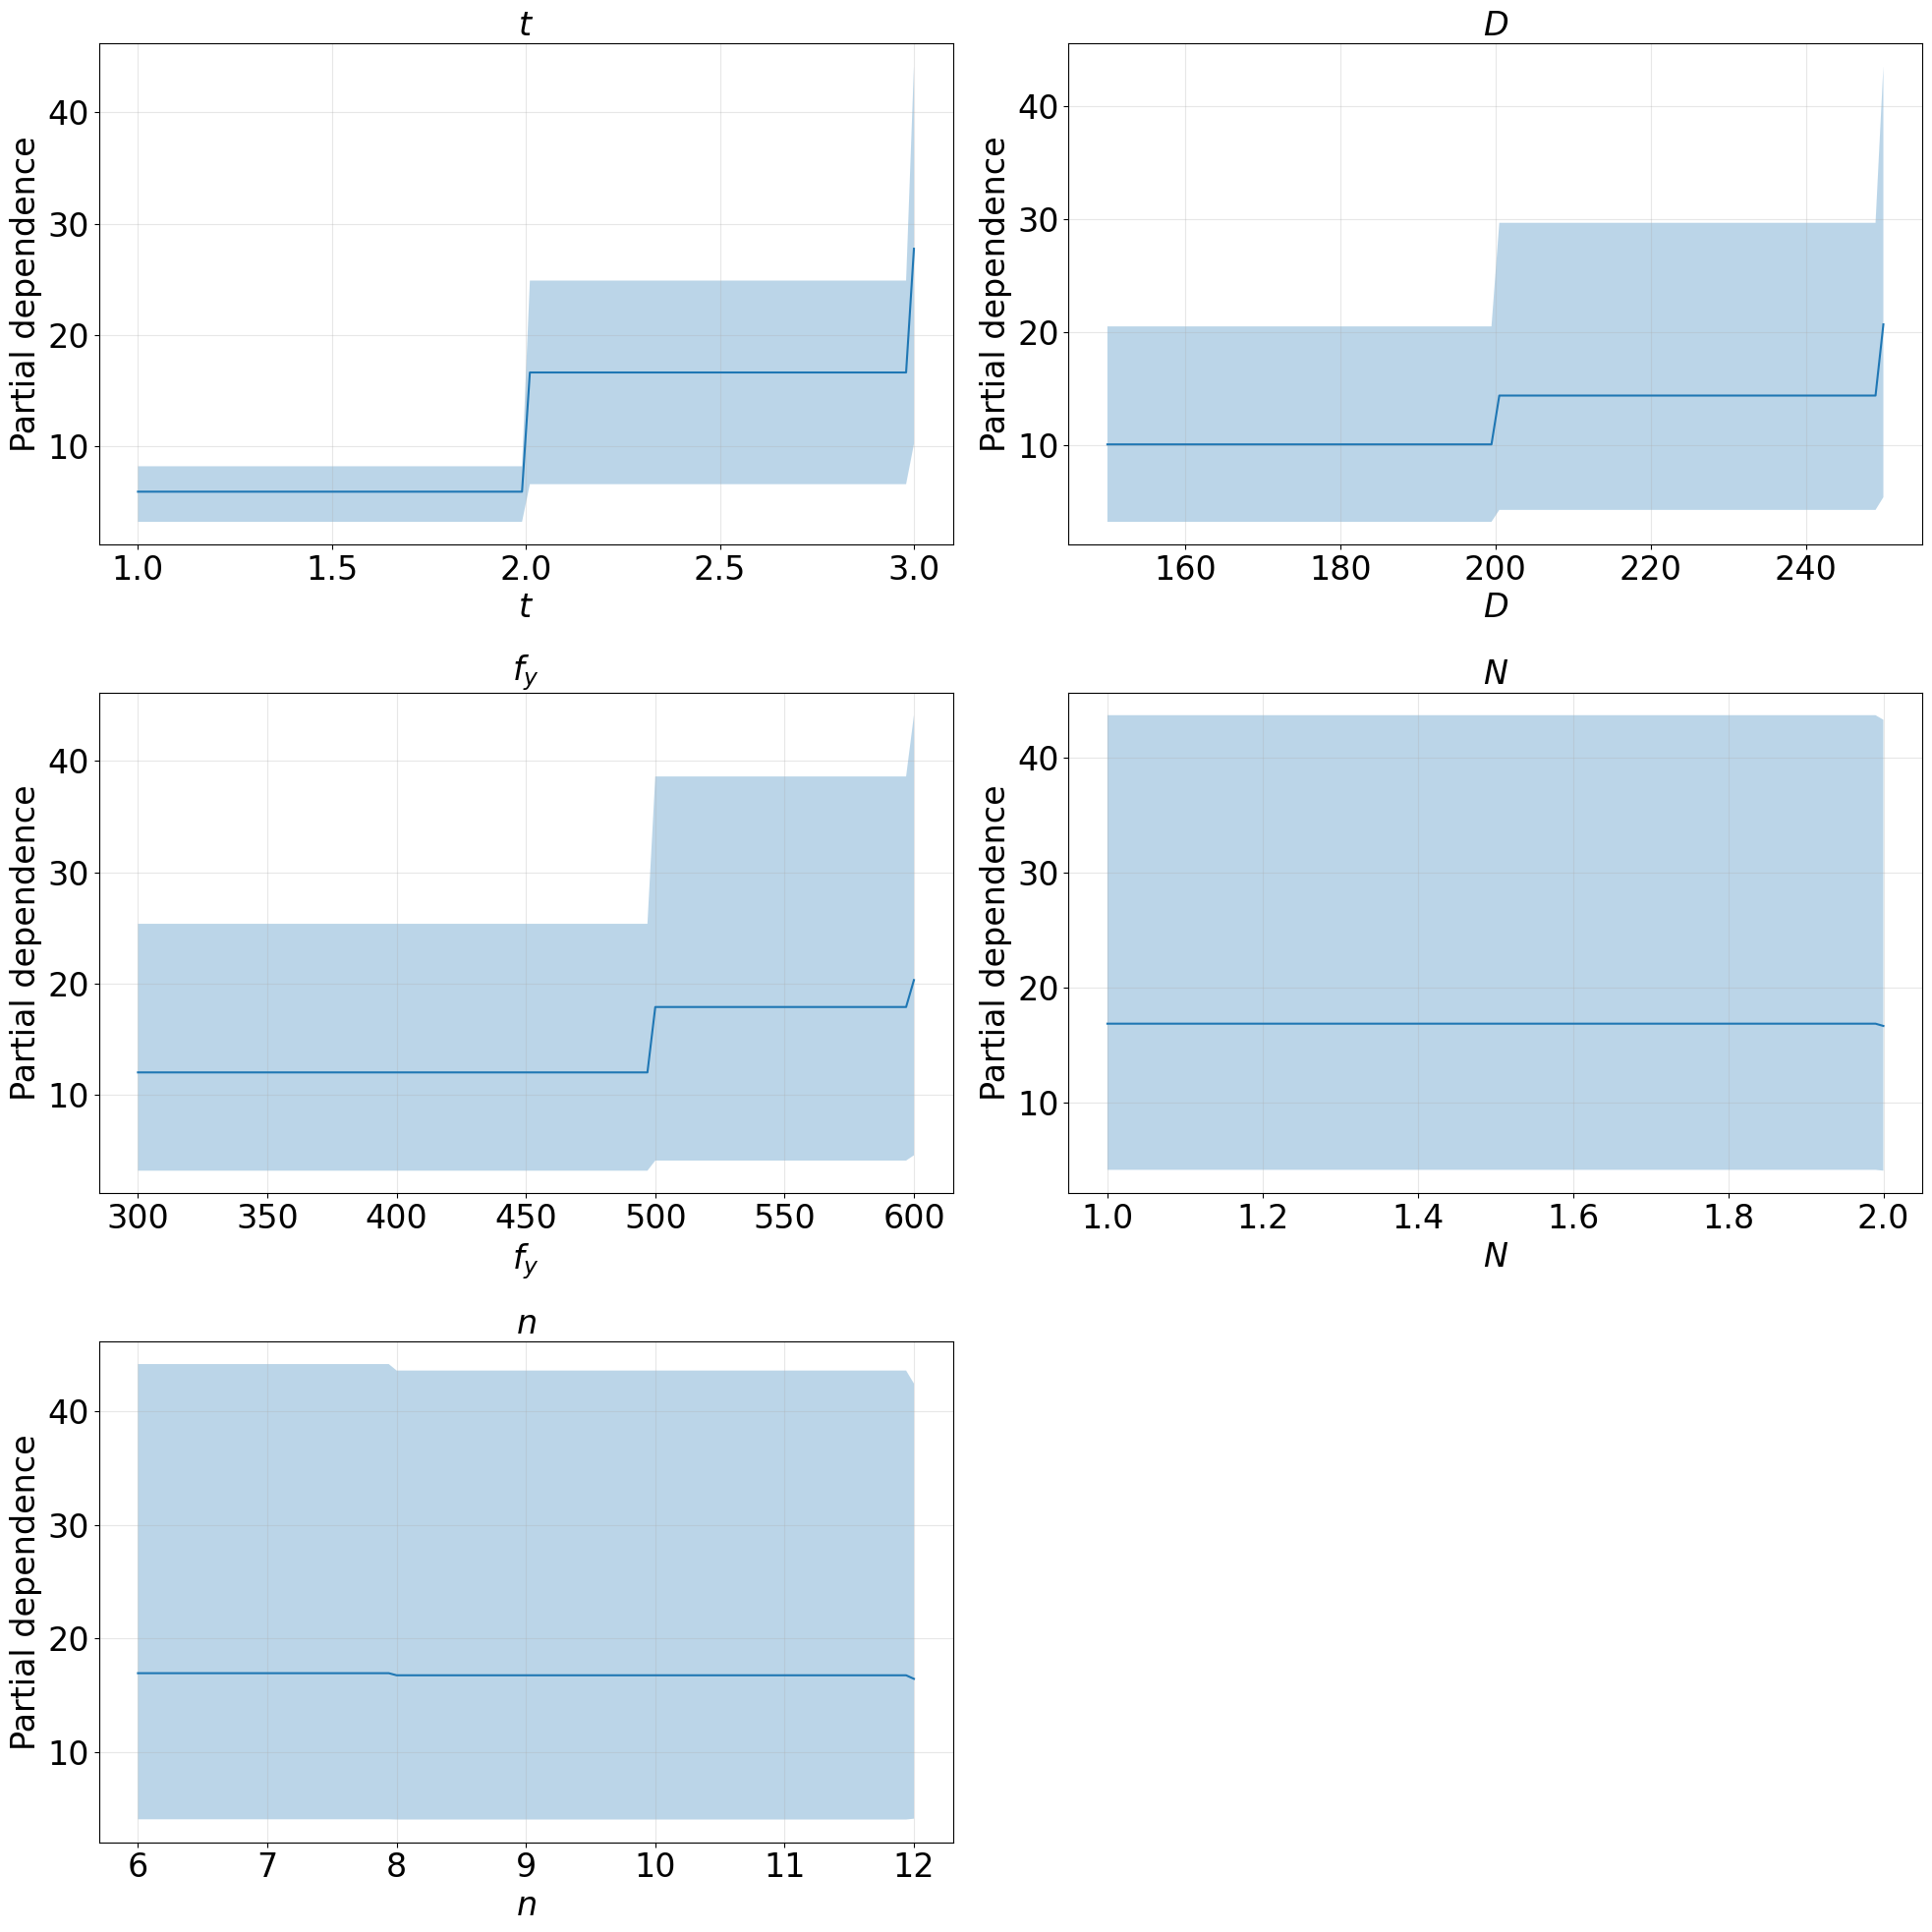

Saved PDP figure to: figs/Partial_Dependence_Plots11.pdf


In [52]:
"""
Partial Dependence Plots (robust version)

- Reads features/target from Data.xlsx (assumes LAST column is the target).
- Uses your trained XGBoost model referenced as `xgb`.
  If `xgb` is not defined, it will try to load 'xgb_model.pkl' via joblib.
- Plots PDPs for the requested feature indices, skipping any that are out of range.
- Saves to 'Partial_Dependence_Plots11.pdf'.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 1) Load data
# -----------------------------
DATA_PATH = "datasets/Data.xlsx"  # change if needed
df = pd.read_excel(DATA_PATH, engine="openpyxl")

# Assume last column is the target; everything else = features
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
feature_cols = df.columns[:-1].tolist()  # names of feature columns

# -----------------------------
# 2) Get / load trained model
# -----------------------------
try:
    # Expect a trained XGBoost model to exist as `xgb` in the environment
    trained_model = xgb  # noqa: F821  # (this line uses your existing variable)
except NameError:
    # Fallback: try loading a pickled model
    trained_model = None
    try:
        import joblib
        trained_model = joblib.load("xgb_model.pkl")  # provide your path if different
        print("Loaded model from 'xgb_model.pkl'.")
    except Exception as e:
        raise RuntimeError(
            "No variable `xgb` found and could not load 'xgb_model.pkl'. "
            "Please either define `xgb` (your trained model) in the session "
            "or update the path to a pickled model."
        ) from e

# -----------------------------
# 3) Labels (TeX-style) by position (optional)
#    If your dataset has fewer columns than labels, we safely slice.
# -----------------------------
tex_labels_full = [
    r"$D$", r"$B_f$", r"$B_l$", r"$t$", r"$L_{sl}$", r"$W_{sl}$",
    r"$S_{sl}$", r"$B_{sl}$", r"$N$", r"$n$", r"$f_y$", r"$M$"
]
# Align labels list length with actual number of feature columns
tex_labels = tex_labels_full[:len(feature_cols)]

def label_for_index(i: int) -> str:
    # Prefer TeX label if available; fallback to actual column name
    if 0 <= i < len(tex_labels):
        return tex_labels[i]
    return feature_cols[i]

# -----------------------------
# 4) Custom PDP function
# -----------------------------
def plot_partial_dependence_custom(
    model,
    Xmat: np.ndarray,
    feature_idx: int,
    feature_name: str,
    ax,
    resolution: int = 100,
    percentile_low: float = 0.1,
    percentile_high: float = 99.9,
    ci_percentiles=(2.5, 97.5),
):
    """
    Computes a 1D partial dependence by sweeping `feature_idx` over a percentile grid,
    holding other features at their observed values, and averaging predictions.
    Also shades a band between the given CI percentiles across predictions.
    """
    col = Xmat[:, feature_idx]
    lo = np.percentile(col, percentile_low)
    hi = np.percentile(col, percentile_high)

    # Edge case: constant feature -> avoid zero-width linspace errors
    if np.isclose(lo, hi):
        values = np.array([lo])
    else:
        values = np.linspace(lo, hi, resolution)

    results = []
    for val in values:
        X_copy = Xmat.copy()
        X_copy[:, feature_idx] = val
        preds = model.predict(X_copy)  # shape: (n_samples,)
        results.append(preds)

    results = np.vstack(results)  # shape: (n_values, n_samples)
    means = results.mean(axis=1)
    lower = np.percentile(results, ci_percentiles[0], axis=1)
    upper = np.percentile(results, ci_percentiles[1], axis=1)

    ax.plot(values, means, label="Partial Dependence")
    ax.fill_between(values, lower, upper, alpha=0.3)
    ax.set_title(str(feature_name), fontsize=24)
    ax.set_xlabel(str(feature_name), fontsize=24)
    ax.set_ylabel("Partial dependence", fontsize=24)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis="both", which="major", labelsize=24)

# -----------------------------
# 5) Choose features to plot
#    (Original request: [3, 0, 10, 11, 8, 9])
#    We’ll auto-skip any out-of-range indices to avoid IndexError.
# -----------------------------
requested_feature_indices = [3, 0, 10, 11, 8, 9]

n_features = X.shape[1]
valid_indices = [i for i in requested_feature_indices if 0 <= i < n_features]
dropped = [i for i in requested_feature_indices if i not in valid_indices]

if dropped:
    print(f"Skipping out-of-range indices (feature count = {n_features}): {dropped}")

# If nothing valid (edge case), default to first up to 6 features
if not valid_indices:
    valid_indices = list(range(min(6, n_features)))

# -----------------------------
# 6) Make subplots and draw
# -----------------------------
n_plots = len(valid_indices)
rows = (n_plots + 1) // 2
fig, axs = plt.subplots(rows, 2, figsize=(20, 20))
axs = np.atleast_1d(axs).ravel()  # flatten even if rows==1

for ax, idx in zip(axs, valid_indices):
    name = label_for_index(idx)
    plot_partial_dependence_custom(trained_model, X, idx, name, ax)

# Remove unused axes (if any)
for ax in axs[len(valid_indices):]:
    fig.delaxes(ax)

plt.tight_layout()
OUTFILE = "figs/Partial_Dependence_Plots11.pdf"
plt.savefig(OUTFILE, bbox_inches="tight")
plt.show()

print(f"Saved PDP figure to: {OUTFILE}")
